<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/23_Pro_%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Pro

Макс 10 баллов

В одной из баз: hh или квартир, сделайте callback, который будет выводить на каждой эпохе следующее:

Текущую mae.
График mae по всем эпохам на обучающей и проверочной выборках.

Текущий scatterplot, где отображаются предсказанные и истинные значения.

Время обучения на эпохе, время обучения суммарное и сколько времени остаётся до конца обучения.

Изменял бы шаг обучения, если начинается “пила” на графике ошибки (mae), или график выходит на плато.

Сохраняет сеть с лучшей точностью в .h5 файл.

*желательно использовать clear_output и verbose=0

**callback должен быть самописный, нельзя использовать готовые

# Загрузка данных

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import random 
import math

import re 
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

import time
import os # Для работы с файлами


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/moscow.csv', sep = ';')

In [ ]:
df.head(5)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
3,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."


In [ ]:
df = df.iloc[::2,:] #выбираем нечетные строки, т.к. в четных строки для комментариев
data = df.values # добавляем значения в numpy array


In [ ]:
df.head(5)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...


In [ ]:
print(df.columns) #смотрим имена колонок данных
#Мы будем использовать

#В xTrain - база числовых значени
#Комнат
#Метро / ЖД станции
#От станции
#Дом
#Балкон
#Санузел
#Площадь

#В xTrainC - база текстов о квартирах
#Примечание

#В yTrain
#Цена, руб.

#Остальные колонки игнорируем

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


#Функции парсинга

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=2126

In [ ]:
#Во всех функция дальше
#d - описание квартиры, одна строка из data1

#Вычисляем количество комнат
#maxRoomCount - максимальное число комнат в квартире
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] #Получаем строку с числом комнат

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) #Пробуем превратить строку в число
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount #Если число комнат больше максимального, то присваиваем максимальное
  except: #Если не получается превратить строку в число
    if (roomsCountStr == roomsCountStr): #Проверяем строку на nan (сравнение с самим собой)
      if ("Ст" in roomsCountStr): #Еcть строка = "Ст", значит это Студия
        roomsCount = maxRoomCount + 1

  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) #Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2) #Превращаем в категорию
  #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] #Получаем строку метро
  metro = 0
  
  if (metroStr in allMetroNames): #Если находим метро во всех названиях
    metro = allMetroNames.index(metroStr)+1 #Присваиваем индекс
    #+1 так как 0 зарезервирован на неопознанное метро
    
  return metro

#Получаем тип метро
#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс
  
  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку
  
  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте
  
  #ЕСли строка не равна nan  
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 #Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 #На транспорте

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0
  
  #Число классов дистанции
  metroDistanceClasses = 7
  
  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #Мы создадим вектор длины 3*7 = 21
  #Будем преобразовывать индекс расстояния 0-6 в 0-20
  #Для типа "Пешком" - ничего не меняем
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14
    
  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""
  
  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа
  
  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажнгости дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1 

        if (int(floorStr) == int(floorsStr)): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] #Полуаем строку
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  #Проверяем на nan
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)
  
  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] #Поулачем строку площади
  
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0
    
  return area

#Получаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку
  
  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0
  
  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки
  
  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  
  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  #Всевращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  #Зашружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

# Создание выборки


In [ ]:
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип (getRoomsCount(d, 30) == 1)
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)
print(xTrain.shape)

(62504, 109)


#Парсинг текста

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=2924

In [ ]:
###########################
# Очистка текста и превращение в набор слов
##########################
def text2Words(text):

  #Удаляем лишние символы
  text = text.replace(".", "")# удаляем лишние символы
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() #Переводим в нижний регистр
  
  
  words = [] #Тут будут все слов
  currWord = "" #Тут будет накапливаться текущее слово, между двумя пробелами
  
  #идём по всем символам
  for symbol in text:
    
    if (symbol != "\ufeff"): #Игнорируем системынй символ в начале строки
      if (symbol != " "): #Если символ не пробел
        currWord += symbol #То добавляем вимвол в текущее слово
      else: #Если символ пробел
        if (currWord != ""): 
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = "" #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое
  #Если не сделать, то потеряем финальное слово, потому что текст чаще всего заканчивается на не пробел
  if (currWord != ""):
        words.append(currWord)
  
  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):
  
  #Создаём словарь, в котором будут слова и количество их поялвений во всём текста
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 #И увеличиаем количество появлений текущего слова на 1

  #Выцепляем лист из словаря
  wordsList = list(wCount.items())
  #И сортируем по частоте появления
  wordsList.sort(key = lambda i:i[1], reverse=1)
  #key = lambda i:i[1] - говорит, что сортировать надо по частоте появления
  #В i[0] у нас слово, в i[1] - частота появления
  #reverse=1 говорить сортироваться по убыванию

  sortedWords = [] #Тут будет лист всех отсортированных слов

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0]) #Докидываем слово в лист отсортированных слов

  #Это словарь слово - индекс
  #Изначально заполнен всеми словами
  #У всех индекс 0
  wordIndexes = dict.fromkeys(allWords, 0)
  #Проходим по всем словам
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1 #Ставим индекс = индекс слова в отсортированном листе слов + 1
    #+1 потому, что индекс 0 резервируем под неопознанные слова

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  #Идём по всем словая
  for word in words:
    
    wordIndex = 0 #Тут будет индекс слова, изначально 0 - слово неопознано
    wordInVocabulary = word in vocabulary #Проверяем, есть ли слово в словаре
    
    #Если слово есть в словаре
    if (wordInVocabulary):
      index = vocabulary[word] #Индекс = индексу слова в словаре
      if (index < maxWordsCount): #Если индекс ниже maxWordsCount - черты отсечения слов
        wordIndex = index #То записываем индекс
      #Иначе останется значение 0
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)
  
  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 #В позицию нужного индекса ставим 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []
  
  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount)) #Добавляем в итоговый набор текущий вектор, преобразованный в bag of words
    
  return np.array(out)


###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающся выборка
  allTextComments = "" #Тут будуте все тексты вместе для словаря
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try: 
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
##########################
def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
# И с приведением к стандартной длине всех векторов - cropLen
##########################
def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

# Создание xTrain (cобираем по текстам)

In [ ]:
xTrainC, allTextComments = getXTrainComments (data1)  #создали обучающую выборку по текстам и полную для словаря
allWords = text2Words(allTextComments) #собрали полный текст в слова
print(len(allWords))
allWords = allWords[::10] # берем 10% слов т.к. словарь долго формируется , каждое 10е берем
print(len(allWords))


6942474
694248


In [ ]:
# Создаем словарь
vocabulary = createVocabulary(allWords)
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000) # преобразуем xTrain  в BOW


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
#Выводим раземры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62504, 109)
(62504, 2000)
(62504,)


In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #создали нормировщик с нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1,1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1,1)).flatten() # нормировали данные нормировщиком

#смотрим размер и выводим 2 примера для сравнения ненормированных и нормированных данных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])



(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
#Нормируем цену квартиры - выход сети
yScaler = StandardScaler() #создаем нормировщик
yScaler.fit(yTrain.reshape(-1,1)) #обучили на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1,1)) # нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])


(62504, 1)
19500000.0
[0.45013]


In [ ]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

1500000.0 3000000015.0
[-0.3458729] [132.25494456]


In [ ]:
#создаем проверочную выборку
splitVal = 0.2  #процент под проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/Базы/xTrainScaled', xTrainScaled)
np.save('/content/drive/MyDrive/Colab Notebooks/Базы/xTrainC01', xTrainC01)
np.save('/content/drive/MyDrive/Colab Notebooks/Базы/yTrainScaled', yTrainScaled)

# Нейросеть

In [ ]:
def on_epoch_end_for_moscow_data(epoch, logs):
  # обработка тестовых данных
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  test_absDelta = abs(delta) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(test_absDelta) / (1e+6 * len(test_absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей
  test_m = round(sum(test_absDelta) / (1e+6 * len(test_absDelta)), 3)

  # сохранение сети если полученная средняя ошибка минимальна 
  if epoch > 0:
    if  test_m < min(mae_test):
      global filename
      if len(filename) > 0:
        os.remove(filename)
      filename = "{}_{}.h5".format(epoch+1, int(test_m*100))
      model.save_weights(filename)

  mae_test.append(test_m)

  # обработка обучающих данных
  pred = model.predict([xTrainScaled[~valMask], xTrainC01[~valMask]]) #выход сети на обучающей выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[~valMask]).flatten() #обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #разность предсказания и правильных цен
  train_absDelta = abs(delta) #модуль отклонения  
  train_m =  round(sum(train_absDelta) / (1e+6 * len(train_absDelta)), 3)
  mae_train.append(train_m)

  # отступ
  print()

  # вывод расчетных параметров
  print("Эпоха:", epoch+1, "/", epochs, " | ", "MAE на тестовой выборке:", test_m, " | ", "MAE на обучающей выборке:", train_m)
  print("Среднее отклонение на тестовой выборке:", round((max(test_absDelta) - min(test_absDelta))/ len(test_absDelta), 2), "руб.", 
        " | ",
        "Среднее отклонение на обучающей выборке:", round((max(train_absDelta) - min(train_absDelta))/ len(train_absDelta), 2), "руб.")
  
  # расчет и вывод временных параметров  
  global last_check_time
  print("Время обучения на эпохе:", int(time.time()-last_check_time), "сек.")

  spend_time = round(time.time() - start_time, 1)
  print("Общее время обучения:", int(spend_time/60), "мин.", int(spend_time - int(spend_time/60) * 60),"сек.")

  wait_time = round(time.time() - last_check_time, 1) * (epochs - epoch - 1)
  print("Время до конца обучения:", int(wait_time/60), "мин.", int(wait_time - int(wait_time/60) * 60),"сек.")

  last_check_time = time.time()
  
  # вывод графиков
  plt_show(test_absDelta, train_absDelta)
  
  # изменение шага, если среднее последниx пяти значений меньше текущего значения
  global learning_rate  
  if min(mae_test) != test_m and round(sum(mae_test[-5:])/5, 3) < test_m:
    if learning_rate > 0.000001:# устанавливаем предел уменьшения
      learning_rate = learning_rate / 10
      set_curr_step(learning_rate, epochs - epoch)
  

# функция для автоматического уменьшения шага
def set_curr_step(rate, remaining_epochs):  
  print("Изменяем значение шага на {}.".format(rate))
  print("Осталось {} эпох.".format(remaining_epochs))
  global epochs
  epochs = remaining_epochs  
  model.compile(optimizer=Adam(lr=rate), loss='mae')
  model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=remaining_epochs, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

# функция вывода графиков
def plt_show(test_delta, train_delta):
  fig, ax = plt.subplots(1,4, figsize=(25,4))

  ax[0].plot(mae_train, color='g') 
  ax[0].set_xlabel('Эпоха обучения')
  ax[0].set_title('Средняя абсолютная ошибка на обучающем наборе')
  ax[0].set_ylabel('Млн. руб.')
 
  ax[1].plot(mae_test, color='orange') 
  ax[1].set_xlabel('Эпоха обучения')
  ax[1].set_title('Средняя абсолютная ошибка на проверочном наборе')
  ax[1].set_ylabel('Млн. руб.')

  
  ax[2].plot(train_delta, color='g') # график scatter мне не нравится ))
  ax[2].set_title('Гистограмма ошибок на обучающем наборе')
  ax[2].set_ylabel('Разность значений')

  ax[3].plot(test_delta, color='orange')
  ax[3].set_title('Гистограмма ошибок на проверочном наборе')
  ax[3].set_ylabel('Разность значений руб.')

  fig.tight_layout()
  plt.show()  
  print()

In [ ]:
print(type(xTrainScaled))
print(type(xTrainC01))
print(type(yTrainScaled))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Эпоха 0 модуль ошибки 1.393

Эпоха: 1 / 30  |  MAE на тестовой выборке: 1.393  |  MAE на обучающей выборке: 1.171
Среднее отклонение на тестовой выборке: 198927.27 руб.  |  Среднее отклонение на обучающей выборке: 40706.94 руб.
Время обучения на эпохе: 10 сек.
Общее время обучения: 0 мин. 10 сек.
Время до конца обучения: 4 мин. 58 сек.


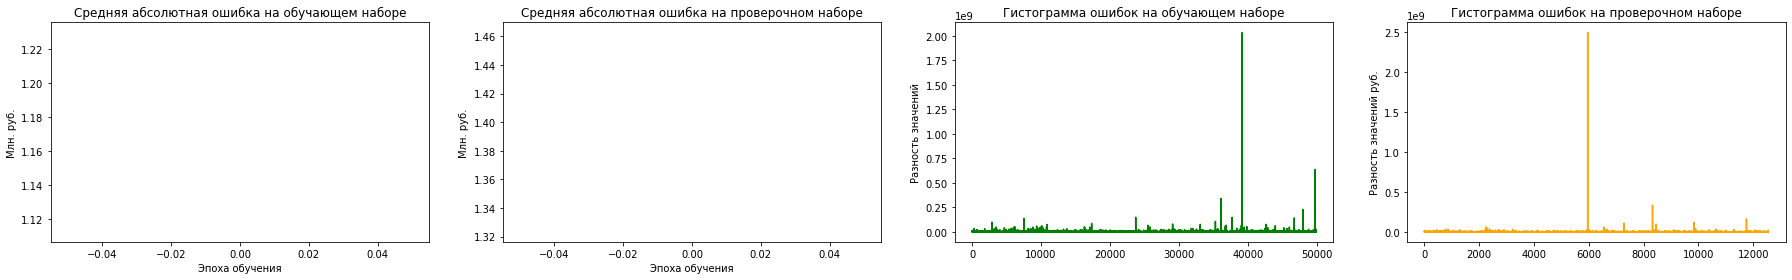


Эпоха 1 модуль ошибки 1.293

Эпоха: 2 / 30  |  MAE на тестовой выборке: 1.293  |  MAE на обучающей выборке: 0.989
Среднее отклонение на тестовой выборке: 193659.42 руб.  |  Среднее отклонение на обучающей выборке: 38618.09 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 0 мин. 20 сек.
Время до конца обучения: 4 мин. 31 сек.


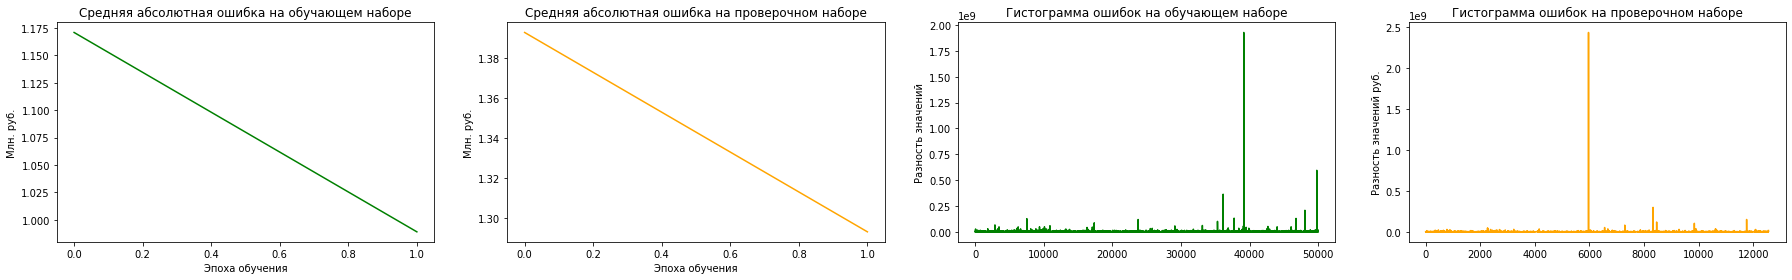


Эпоха 2 модуль ошибки 1.245

Эпоха: 3 / 30  |  MAE на тестовой выборке: 1.245  |  MAE на обучающей выборке: 0.936
Среднее отклонение на тестовой выборке: 181374.53 руб.  |  Среднее отклонение на обучающей выборке: 32891.7 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 0 мин. 30 сек.
Время до конца обучения: 4 мин. 27 сек.


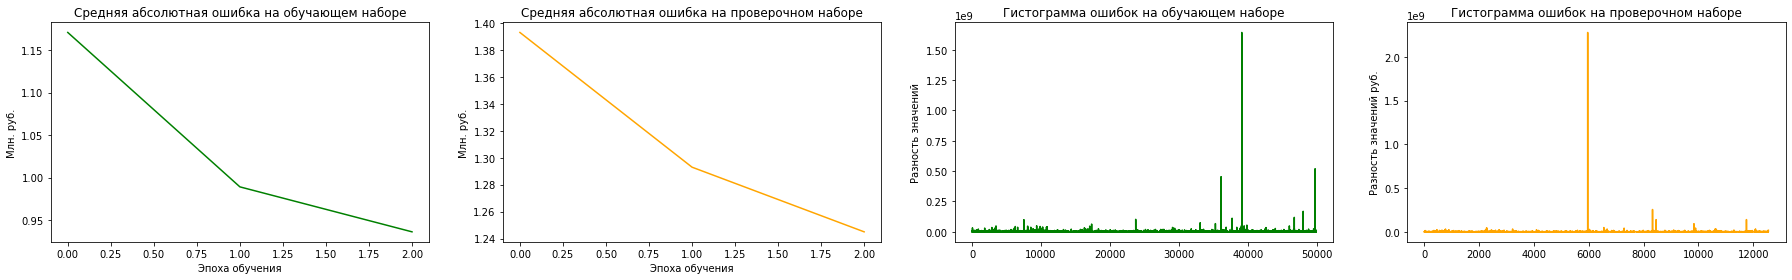


Эпоха 3 модуль ошибки 1.198

Эпоха: 4 / 30  |  MAE на тестовой выборке: 1.198  |  MAE на обучающей выборке: 0.869
Среднее отклонение на тестовой выборке: 148173.18 руб.  |  Среднее отклонение на обучающей выборке: 17580.86 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 0 мин. 39 сек.
Время до конца обучения: 4 мин. 9 сек.


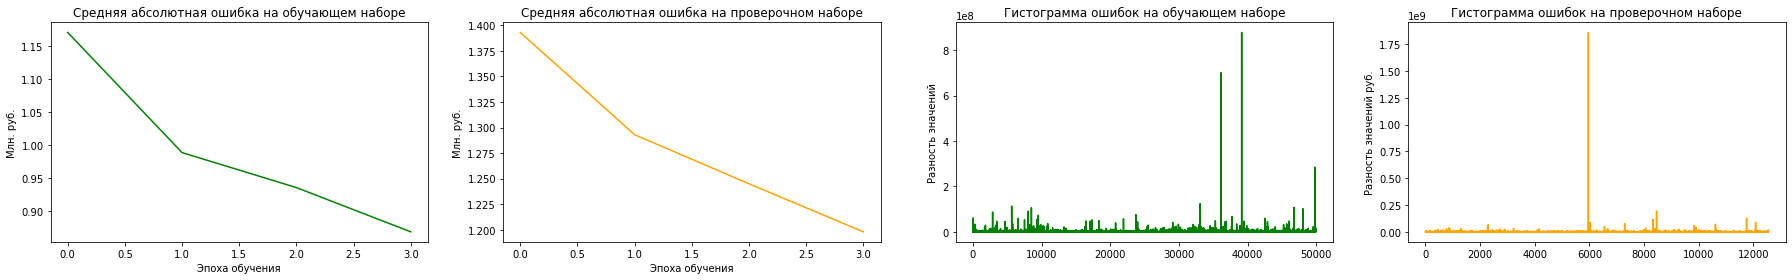


Эпоха 4 модуль ошибки 1.144

Эпоха: 5 / 30  |  MAE на тестовой выборке: 1.144  |  MAE на обучающей выборке: 0.771
Среднее отклонение на тестовой выборке: 164851.11 руб.  |  Среднее отклонение на обучающей выборке: 27692.99 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 0 мин. 49 сек.
Время до конца обучения: 4 мин. 0 сек.


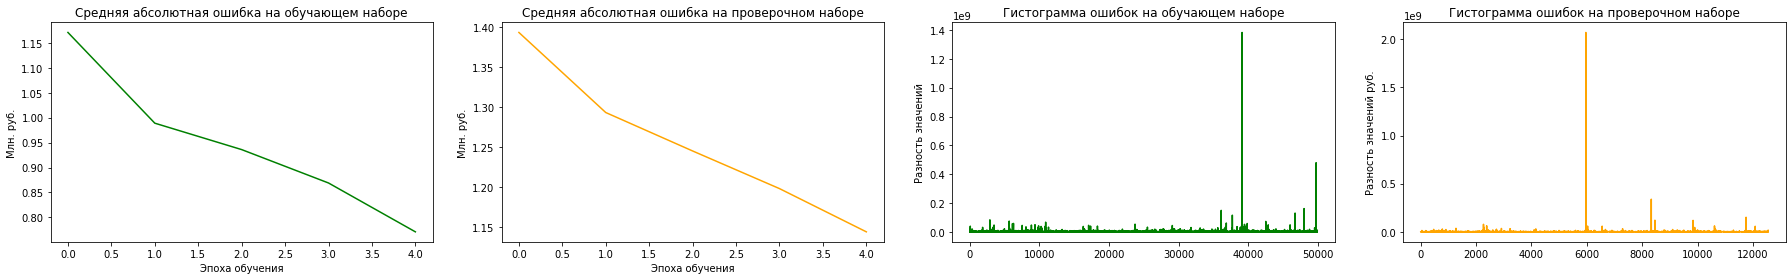


Эпоха 5 модуль ошибки 1.106

Эпоха: 6 / 30  |  MAE на тестовой выборке: 1.106  |  MAE на обучающей выборке: 0.727
Среднее отклонение на тестовой выборке: 106644.01 руб.  |  Среднее отклонение на обучающей выборке: 5766.64 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 0 мин. 58 сек.
Время до конца обучения: 3 мин. 52 сек.


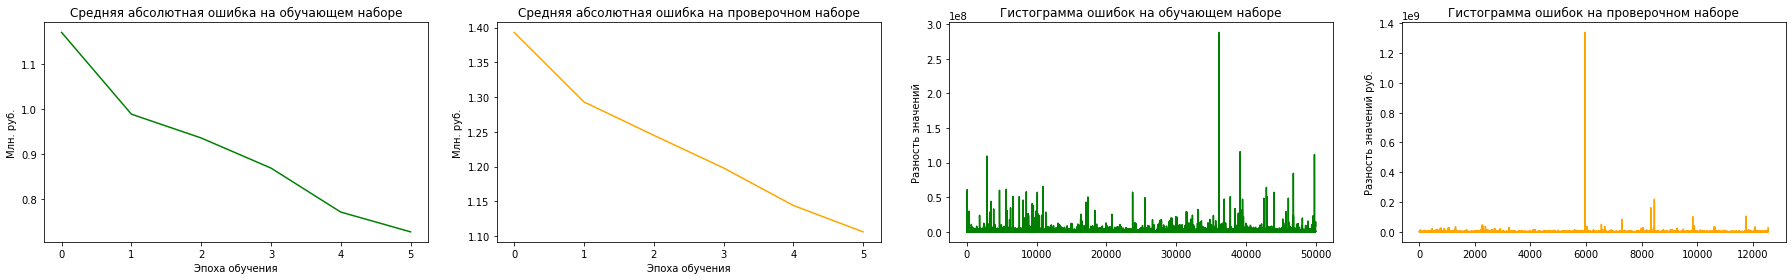


Эпоха 6 модуль ошибки 1.043

Эпоха: 7 / 30  |  MAE на тестовой выборке: 1.043  |  MAE на обучающей выборке: 0.655
Среднее отклонение на тестовой выборке: 125840.34 руб.  |  Среднее отклонение на обучающей выборке: 9899.36 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 1 мин. 8 сек.
Время до конца обучения: 3 мин. 40 сек.


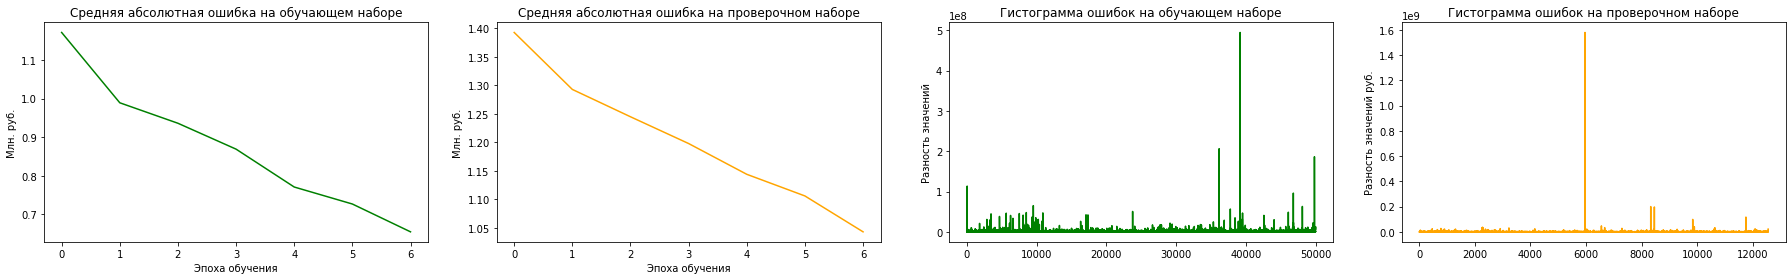


Эпоха 7 модуль ошибки 1.027

Эпоха: 8 / 30  |  MAE на тестовой выборке: 1.027  |  MAE на обучающей выборке: 0.627
Среднее отклонение на тестовой выборке: 135695.29 руб.  |  Среднее отклонение на обучающей выборке: 14526.0 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 1 мин. 18 сек.
Время до конца обучения: 3 мин. 31 сек.


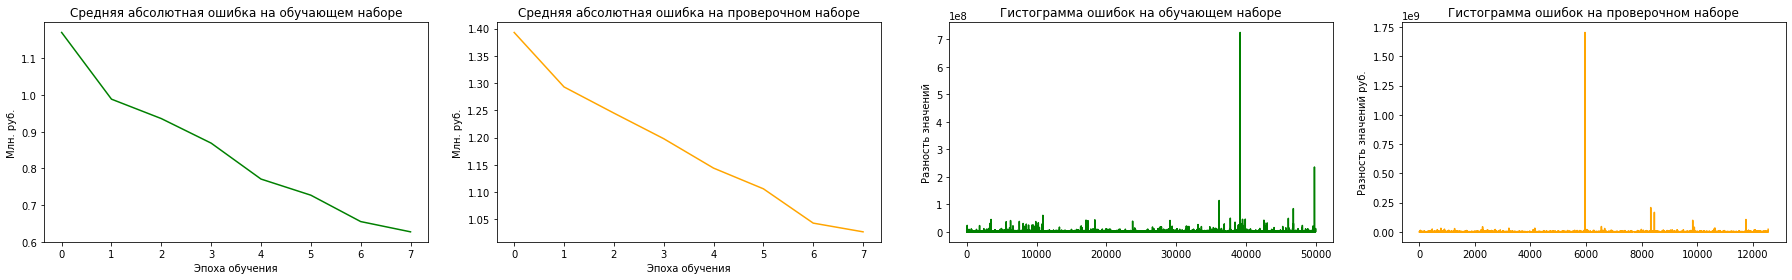


Эпоха 8 модуль ошибки 1.021

Эпоха: 9 / 30  |  MAE на тестовой выборке: 1.021  |  MAE на обучающей выборке: 0.61
Среднее отклонение на тестовой выборке: 130661.26 руб.  |  Среднее отклонение на обучающей выборке: 13317.66 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 1 мин. 27 сек.
Время до конца обучения: 3 мин. 21 сек.


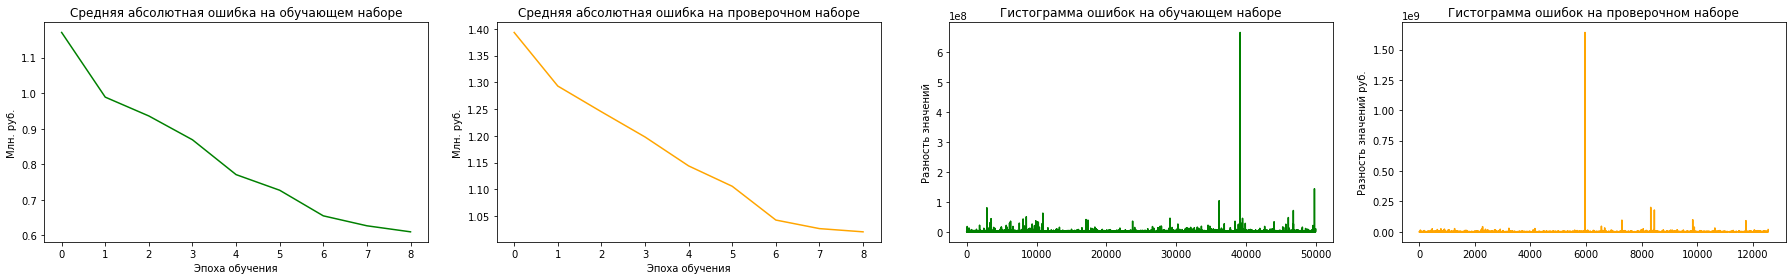


Эпоха 9 модуль ошибки 0.924

Эпоха: 10 / 30  |  MAE на тестовой выборке: 0.924  |  MAE на обучающей выборке: 0.529
Среднее отклонение на тестовой выборке: 87901.19 руб.  |  Среднее отклонение на обучающей выборке: 6338.33 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 1 мин. 37 сек.
Время до конца обучения: 3 мин. 12 сек.


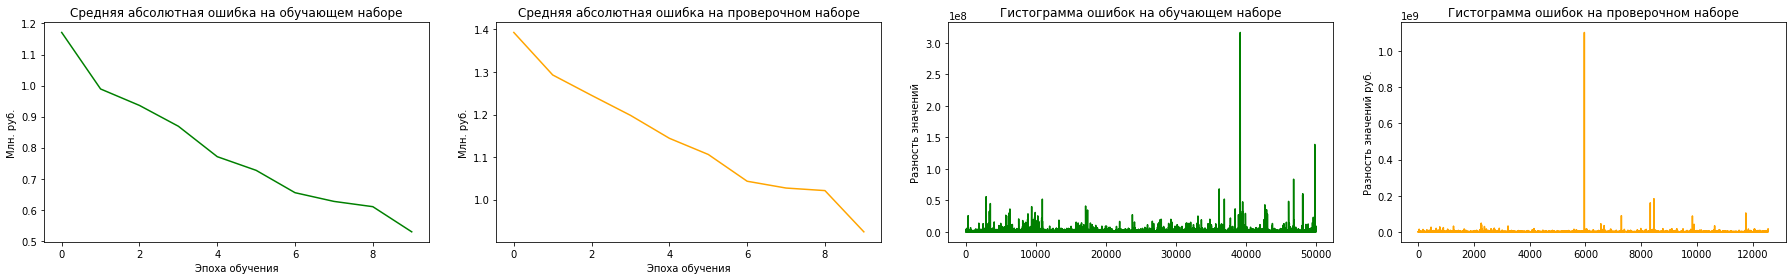


Эпоха 10 модуль ошибки 0.908

Эпоха: 11 / 30  |  MAE на тестовой выборке: 0.908  |  MAE на обучающей выборке: 0.578
Среднее отклонение на тестовой выборке: 64880.57 руб.  |  Среднее отклонение на обучающей выборке: 17318.88 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 1 мин. 47 сек.
Время до конца обучения: 3 мин. 4 сек.


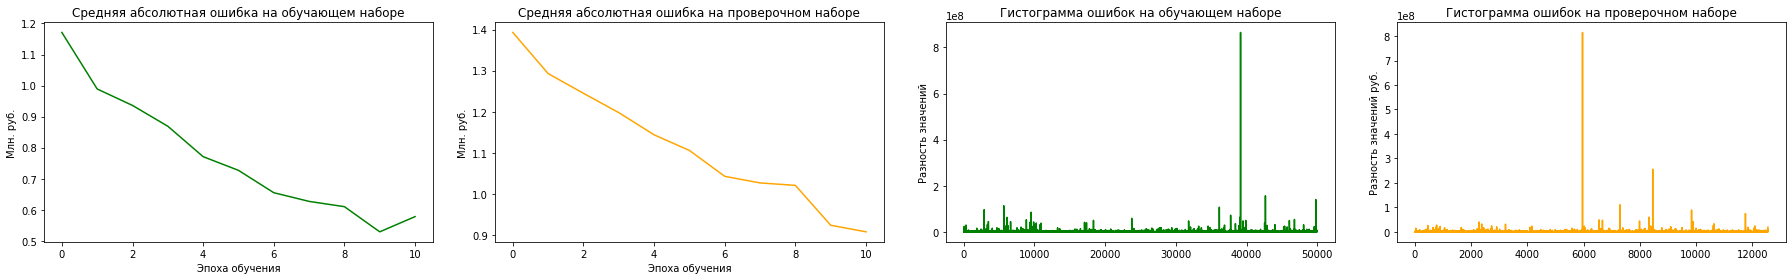


Эпоха 11 модуль ошибки 1.029

Эпоха: 12 / 30  |  MAE на тестовой выборке: 1.029  |  MAE на обучающей выборке: 0.621
Среднее отклонение на тестовой выборке: 105869.69 руб.  |  Среднее отклонение на обучающей выборке: 4522.51 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 1 мин. 56 сек.
Время до конца обучения: 2 мин. 49 сек.


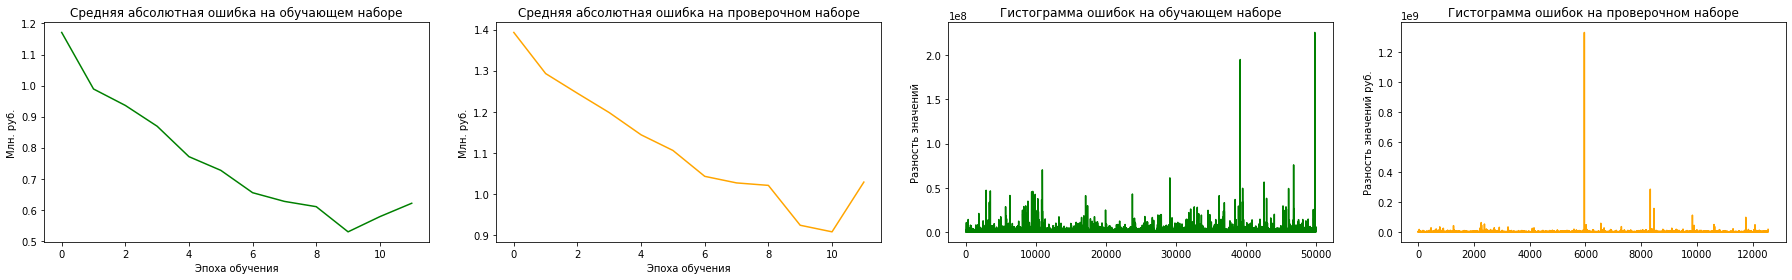


Изменяем значение шага на 0.0001.
Осталось 19 эпох.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Эпоха 0 модуль ошибки 0.858

Эпоха: 1 / 19  |  MAE на тестовой выборке: 0.858  |  MAE на обучающей выборке: 0.404
Среднее отклонение на тестовой выборке: 96221.9 руб.  |  Среднее отклонение на обучающей выборке: 4185.82 руб.
Время обучения на эпохе: 10 сек.
Общее время обучения: 2 мин. 7 сек.
Время до конца обучения: 3 мин. 12 сек.


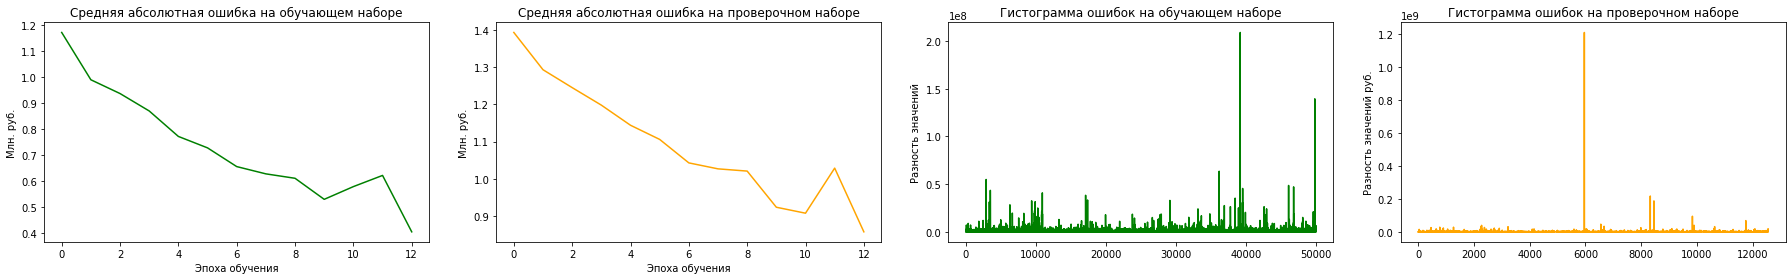


Эпоха 1 модуль ошибки 0.85

Эпоха: 2 / 19  |  MAE на тестовой выборке: 0.85  |  MAE на обучающей выборке: 0.364
Среднее отклонение на тестовой выборке: 100148.28 руб.  |  Среднее отклонение на обучающей выборке: 3184.93 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 2 мин. 16 сек.
Время до конца обучения: 2 мин. 41 сек.


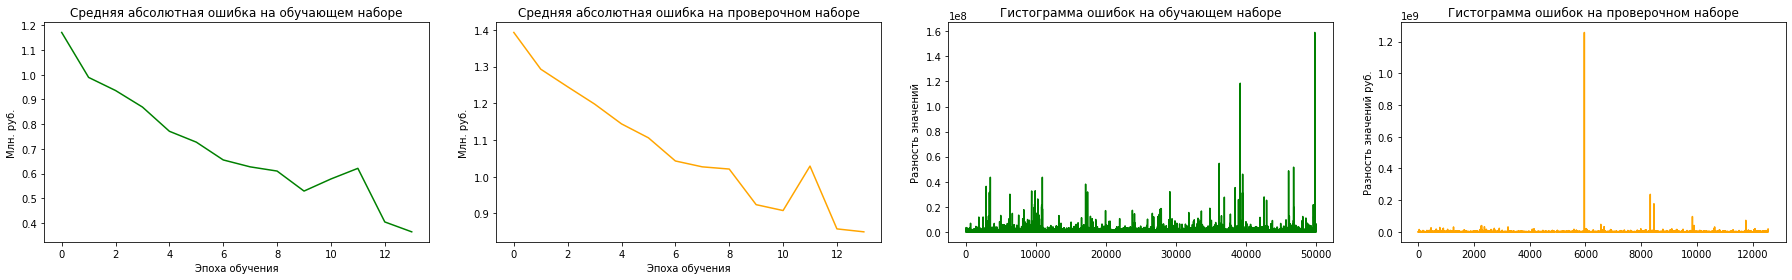


Эпоха 2 модуль ошибки 0.857

Эпоха: 3 / 19  |  MAE на тестовой выборке: 0.857  |  MAE на обучающей выборке: 0.356
Среднее отклонение на тестовой выборке: 110011.83 руб.  |  Среднее отклонение на обучающей выборке: 5011.36 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 2 мин. 26 сек.
Время до конца обучения: 2 мин. 33 сек.


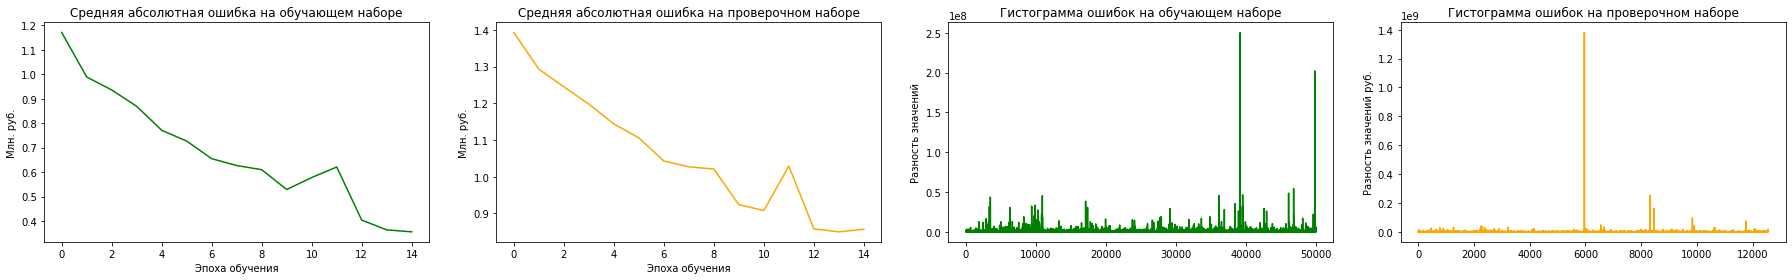


Эпоха 3 модуль ошибки 0.832

Эпоха: 4 / 19  |  MAE на тестовой выборке: 0.832  |  MAE на обучающей выборке: 0.327
Среднее отклонение на тестовой выборке: 96890.82 руб.  |  Среднее отклонение на обучающей выборке: 3791.76 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 2 мин. 36 сек.
Время до конца обучения: 2 мин. 24 сек.


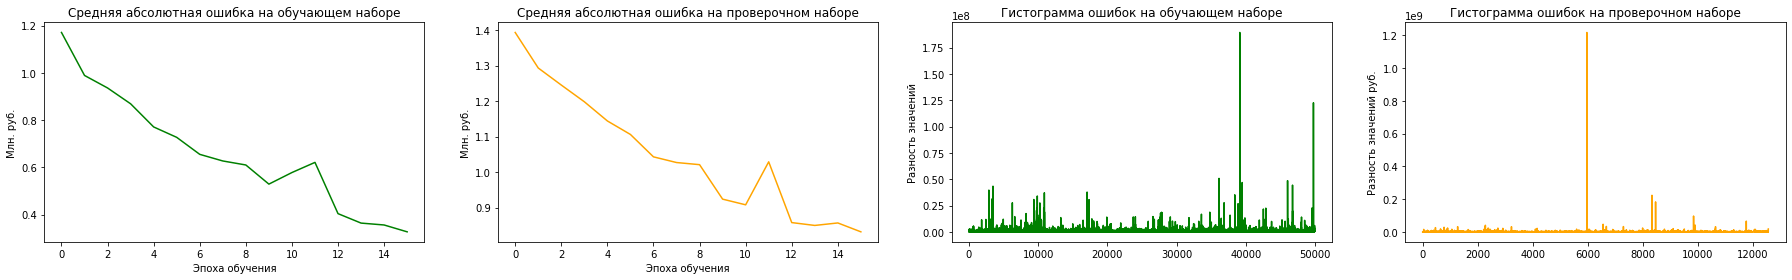


Эпоха 4 модуль ошибки 0.841

Эпоха: 5 / 19  |  MAE на тестовой выборке: 0.841  |  MAE на обучающей выборке: 0.318
Среднее отклонение на тестовой выборке: 109585.25 руб.  |  Среднее отклонение на обучающей выборке: 4747.87 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 2 мин. 45 сек.
Время до конца обучения: 2 мин. 14 сек.


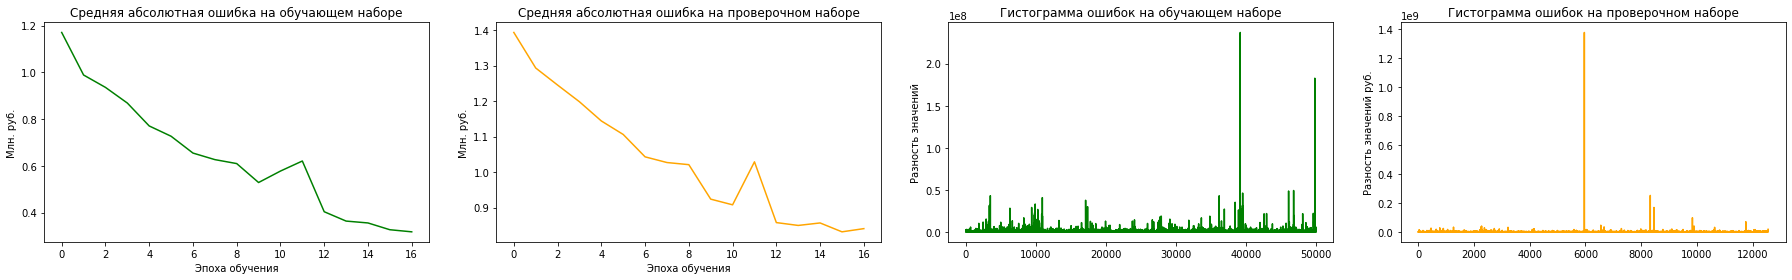


Эпоха 5 модуль ошибки 0.834

Эпоха: 6 / 19  |  MAE на тестовой выборке: 0.834  |  MAE на обучающей выборке: 0.305
Среднее отклонение на тестовой выборке: 106231.42 руб.  |  Среднее отклонение на обучающей выборке: 3092.97 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 2 мин. 55 сек.
Время до конца обучения: 2 мин. 4 сек.


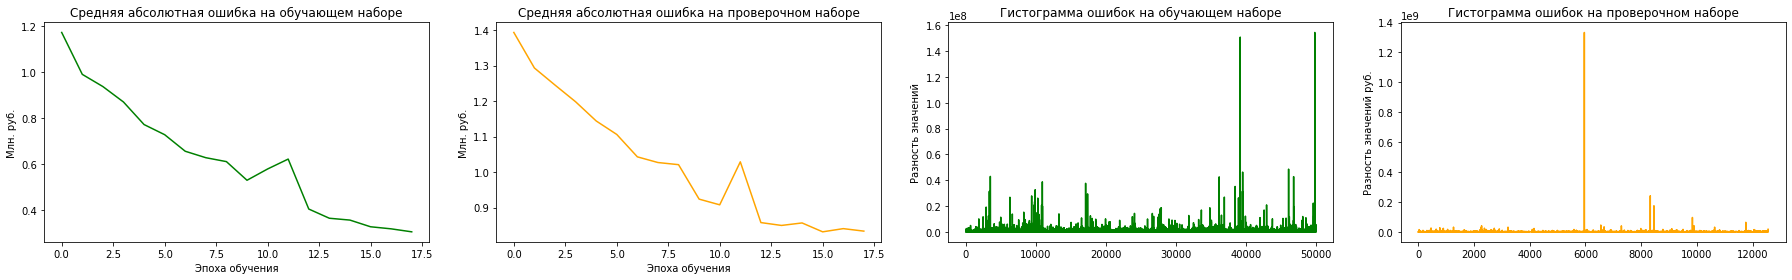


Эпоха 6 модуль ошибки 0.829

Эпоха: 7 / 19  |  MAE на тестовой выборке: 0.829  |  MAE на обучающей выборке: 0.294
Среднее отклонение на тестовой выборке: 104461.6 руб.  |  Среднее отклонение на обучающей выборке: 2753.96 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 3 мин. 5 сек.
Время до конца обучения: 1 мин. 57 сек.


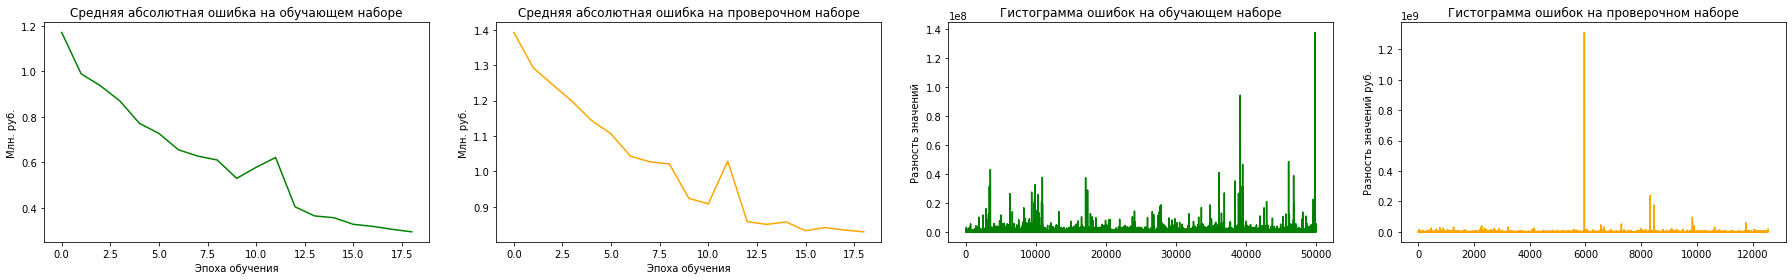


Эпоха 7 модуль ошибки 0.83

Эпоха: 8 / 19  |  MAE на тестовой выборке: 0.83  |  MAE на обучающей выборке: 0.29
Среднее отклонение на тестовой выборке: 107289.02 руб.  |  Среднее отклонение на обучающей выборке: 3023.93 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 3 мин. 14 сек.
Время до конца обучения: 1 мин. 45 сек.


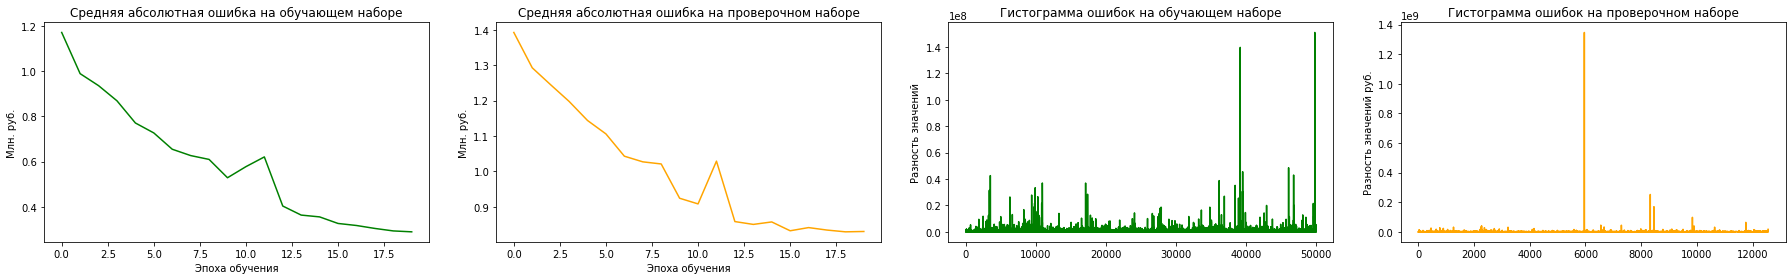


Эпоха 8 модуль ошибки 0.821

Эпоха: 9 / 19  |  MAE на тестовой выборке: 0.821  |  MAE на обучающей выборке: 0.282
Среднее отклонение на тестовой выборке: 103392.81 руб.  |  Среднее отклонение на обучающей выборке: 2371.31 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 3 мин. 24 сек.
Время до конца обучения: 1 мин. 36 сек.


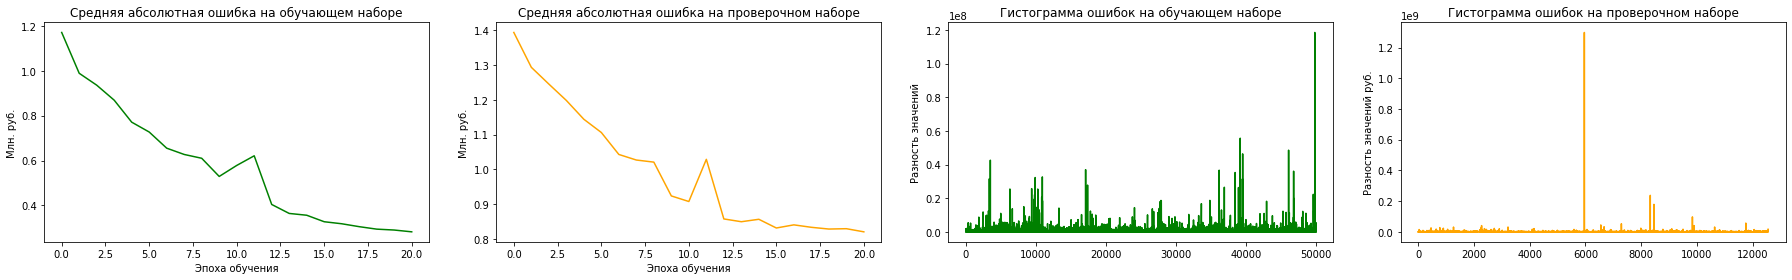


Эпоха 9 модуль ошибки 0.82

Эпоха: 10 / 19  |  MAE на тестовой выборке: 0.82  |  MAE на обучающей выборке: 0.278
Среднее отклонение на тестовой выборке: 103682.4 руб.  |  Среднее отклонение на обучающей выборке: 2422.68 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 3 мин. 33 сек.
Время до конца обучения: 1 мин. 26 сек.


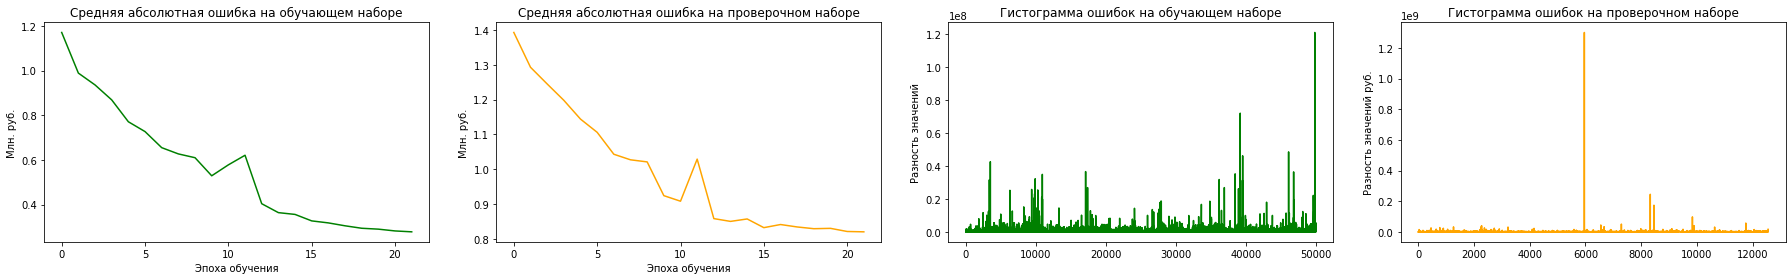


Эпоха 10 модуль ошибки 0.818

Эпоха: 11 / 19  |  MAE на тестовой выборке: 0.818  |  MAE на обучающей выборке: 0.274
Среднее отклонение на тестовой выборке: 102297.31 руб.  |  Среднее отклонение на обучающей выборке: 2094.98 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 3 мин. 43 сек.
Время до конца обучения: 1 мин. 16 сек.


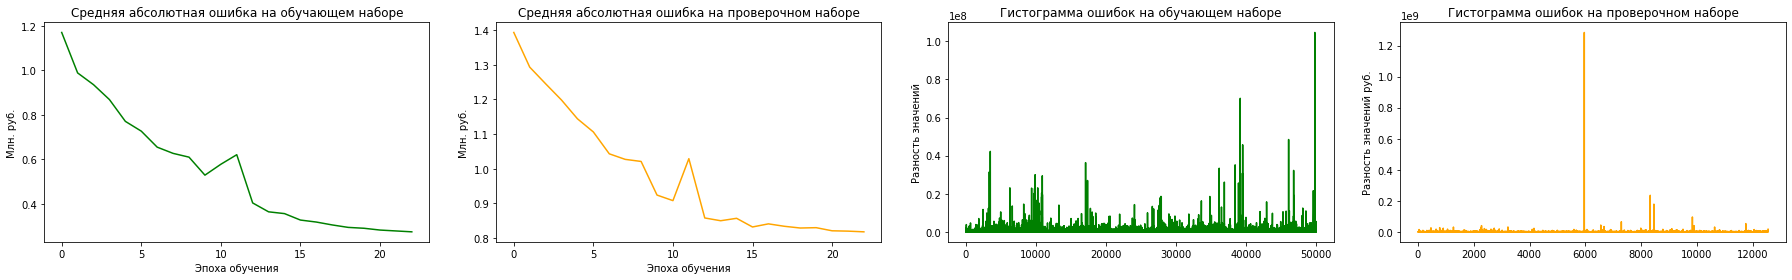


Эпоха 11 модуль ошибки 0.819

Эпоха: 12 / 19  |  MAE на тестовой выборке: 0.819  |  MAE на обучающей выборке: 0.272
Среднее отклонение на тестовой выборке: 104253.31 руб.  |  Среднее отклонение на обучающей выборке: 2241.85 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 3 мин. 52 сек.
Время до конца обучения: 1 мин. 5 сек.


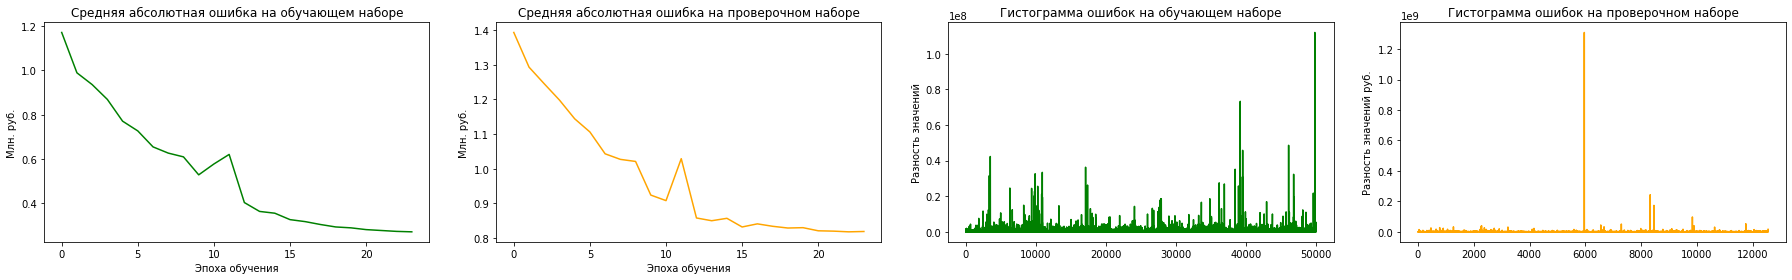


Эпоха 12 модуль ошибки 0.817

Эпоха: 13 / 19  |  MAE на тестовой выборке: 0.817  |  MAE на обучающей выборке: 0.27
Среднее отклонение на тестовой выборке: 103456.12 руб.  |  Среднее отклонение на обучающей выборке: 2033.38 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 4 мин. 2 сек.
Время до конца обучения: 0 мин. 57 сек.


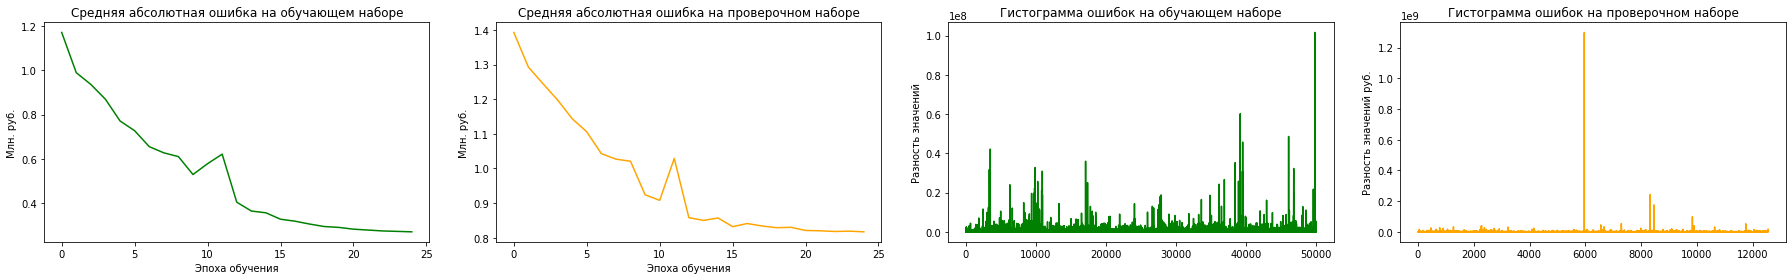


Эпоха 13 модуль ошибки 0.822

Эпоха: 14 / 19  |  MAE на тестовой выборке: 0.822  |  MAE на обучающей выборке: 0.284
Среднее отклонение на тестовой выборке: 102765.36 руб.  |  Среднее отклонение на обучающей выборке: 1766.42 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 4 мин. 11 сек.
Время до конца обучения: 0 мин. 49 сек.


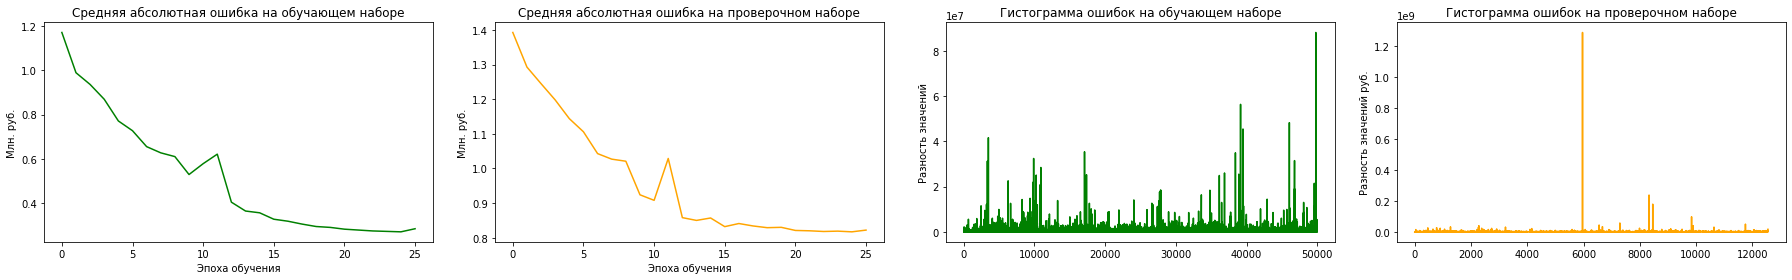


Изменяем значение шага на 1e-05.
Осталось 6 эпох.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Эпоха 0 модуль ошибки 0.811

Эпоха: 1 / 6  |  MAE на тестовой выборке: 0.811  |  MAE на обучающей выборке: 0.256
Среднее отклонение на тестовой выборке: 103135.34 руб.  |  Среднее отклонение на обучающей выборке: 1813.0 руб.
Время обучения на эпохе: 10 сек.
Общее время обучения: 4 мин. 22 сек.
Время до конца обучения: 0 мин. 55 сек.


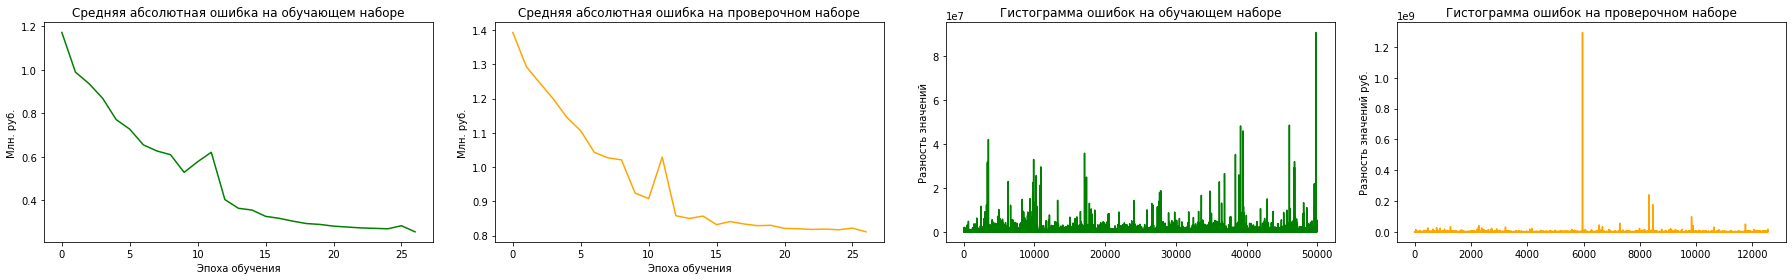


Эпоха 1 модуль ошибки 0.81

Эпоха: 2 / 6  |  MAE на тестовой выборке: 0.81  |  MAE на обучающей выборке: 0.252
Среднее отклонение на тестовой выборке: 102665.5 руб.  |  Среднее отклонение на обучающей выборке: 1741.09 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 4 мин. 32 сек.
Время до конца обучения: 0 мин. 37 сек.


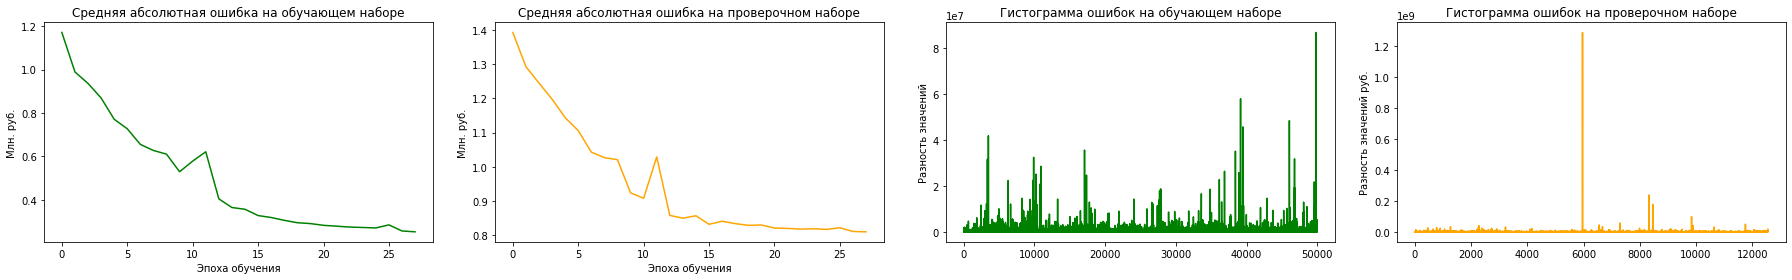


Эпоха 2 модуль ошибки 0.81

Эпоха: 3 / 6  |  MAE на тестовой выборке: 0.81  |  MAE на обучающей выборке: 0.249
Среднее отклонение на тестовой выборке: 102729.08 руб.  |  Среднее отклонение на обучающей выборке: 1745.78 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 4 мин. 41 сек.
Время до конца обучения: 0 мин. 28 сек.


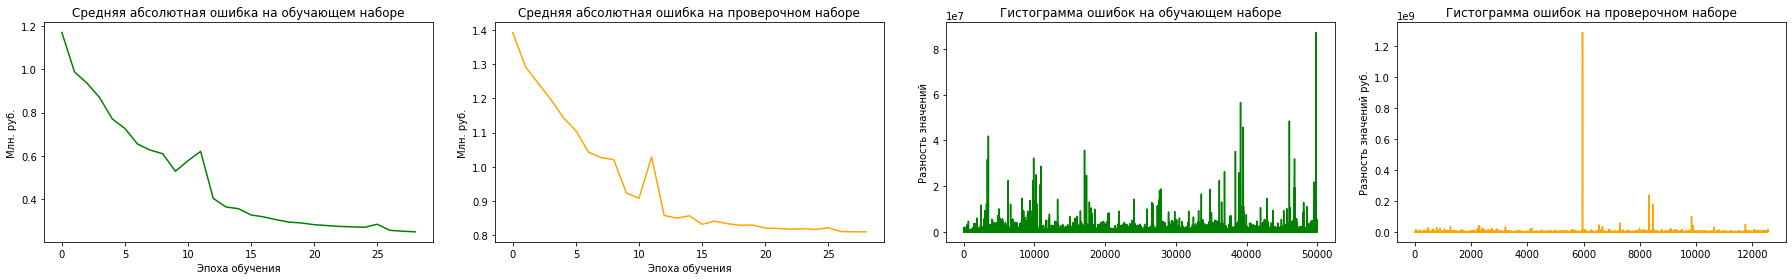


Эпоха 3 модуль ошибки 0.809

Эпоха: 4 / 6  |  MAE на тестовой выборке: 0.809  |  MAE на обучающей выборке: 0.248
Среднее отклонение на тестовой выборке: 102679.79 руб.  |  Среднее отклонение на обучающей выборке: 1736.15 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 4 мин. 51 сек.
Время до конца обучения: 0 мин. 19 сек.


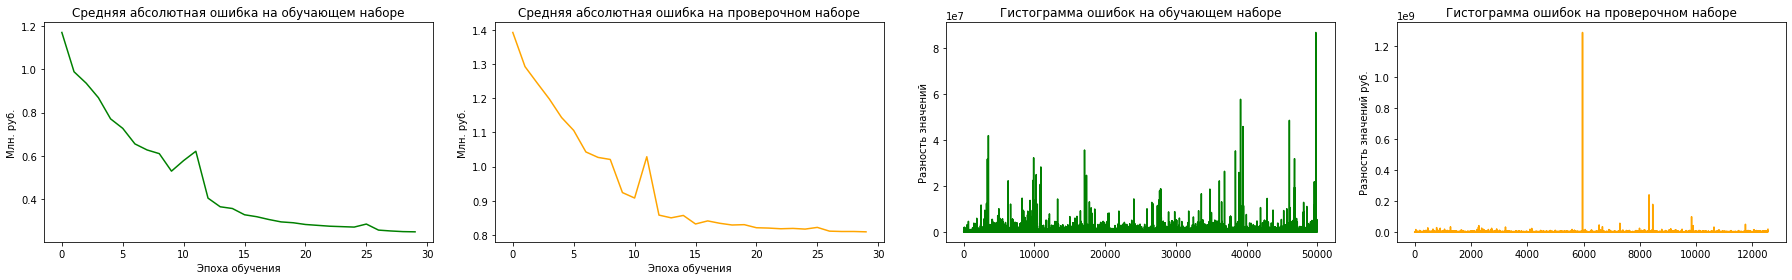


Эпоха 4 модуль ошибки 0.809

Эпоха: 5 / 6  |  MAE на тестовой выборке: 0.809  |  MAE на обучающей выборке: 0.246
Среднее отклонение на тестовой выборке: 102629.68 руб.  |  Среднее отклонение на обучающей выборке: 1724.55 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 5 мин. 0 сек.
Время до конца обучения: 0 мин. 9 сек.


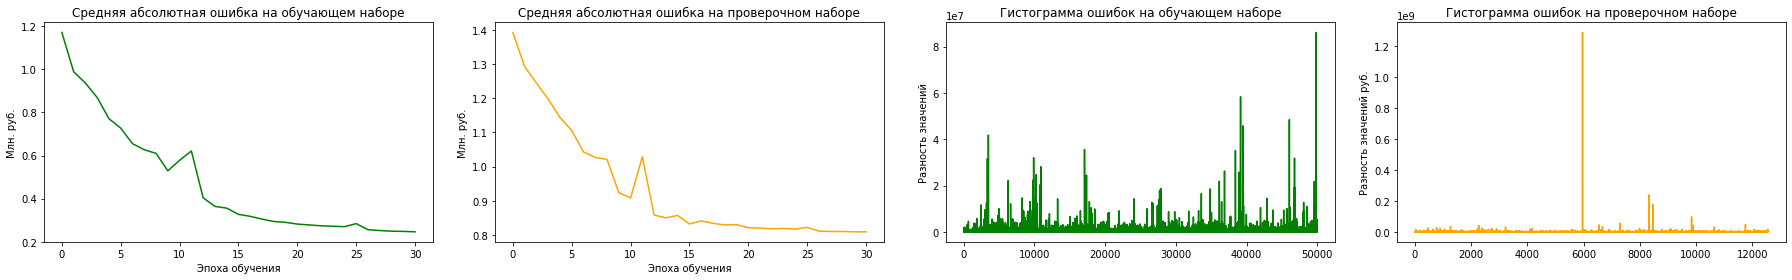


Эпоха 5 модуль ошибки 0.808

Эпоха: 6 / 6  |  MAE на тестовой выборке: 0.808  |  MAE на обучающей выборке: 0.245
Среднее отклонение на тестовой выборке: 102684.63 руб.  |  Среднее отклонение на обучающей выборке: 1725.0 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 5 мин. 10 сек.
Время до конца обучения: 0 мин. 0 сек.


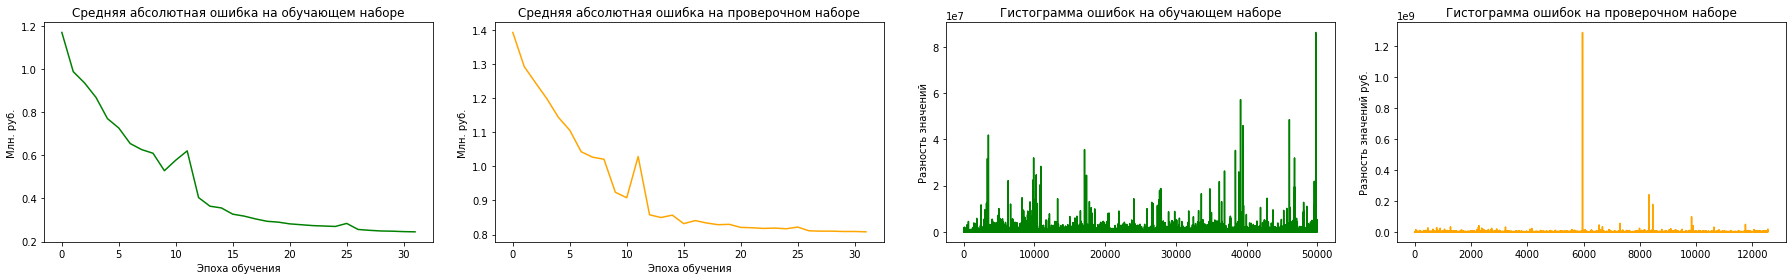


Эпоха 14 модуль ошибки 0.808

Эпоха: 15 / 6  |  MAE на тестовой выборке: 0.808  |  MAE на обучающей выборке: 0.244
Среднее отклонение на тестовой выборке: 102452.02 руб.  |  Среднее отклонение на обучающей выборке: 1687.01 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 5 мин. 19 сек.
Время до конца обучения: -1 мин. -25 сек.


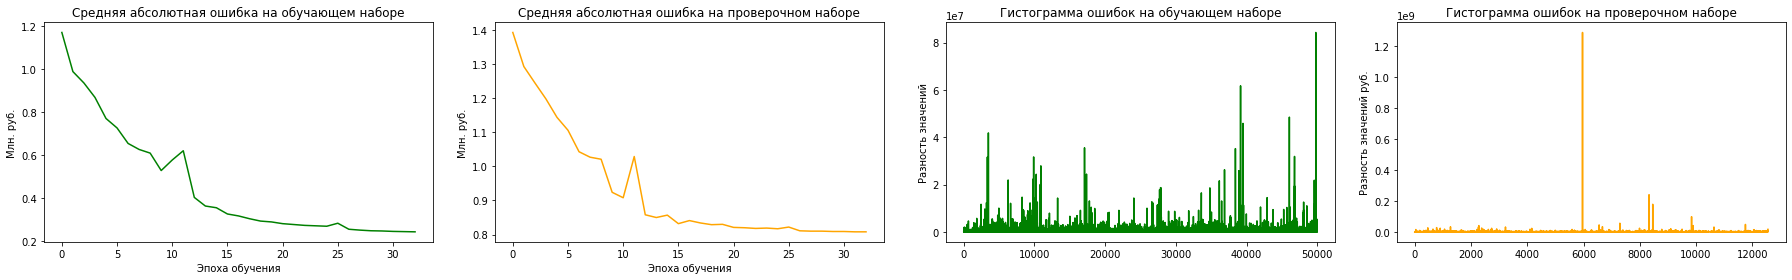


Эпоха 15 модуль ошибки 0.808

Эпоха: 16 / 6  |  MAE на тестовой выборке: 0.808  |  MAE на обучающей выборке: 0.243
Среднее отклонение на тестовой выборке: 102380.9 руб.  |  Среднее отклонение на обучающей выборке: 1664.4 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 5 мин. 29 сек.
Время до конца обучения: -1 мин. -35 сек.


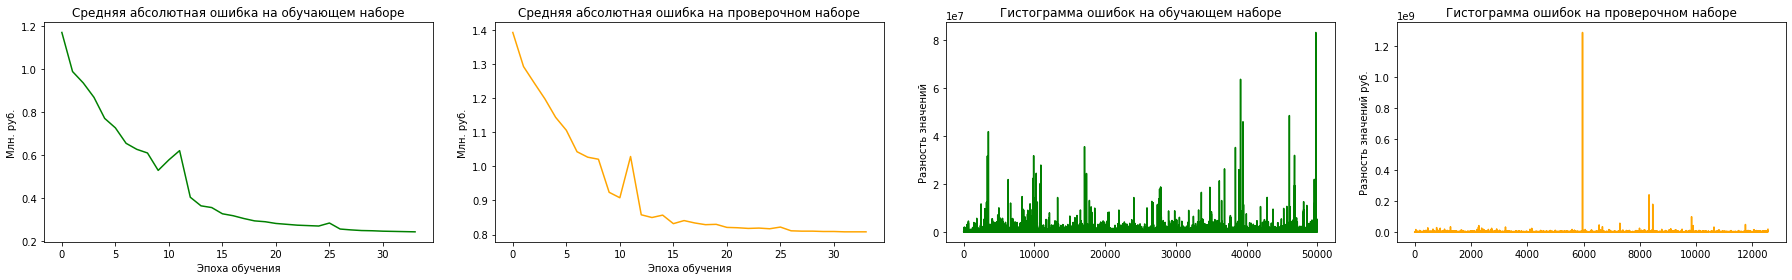


Эпоха 16 модуль ошибки 0.807

Эпоха: 17 / 6  |  MAE на тестовой выборке: 0.807  |  MAE на обучающей выборке: 0.242
Среднее отклонение на тестовой выборке: 101993.77 руб.  |  Среднее отклонение на обучающей выборке: 1603.83 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 5 мин. 38 сек.
Время до конца обучения: -1 мин. -44 сек.


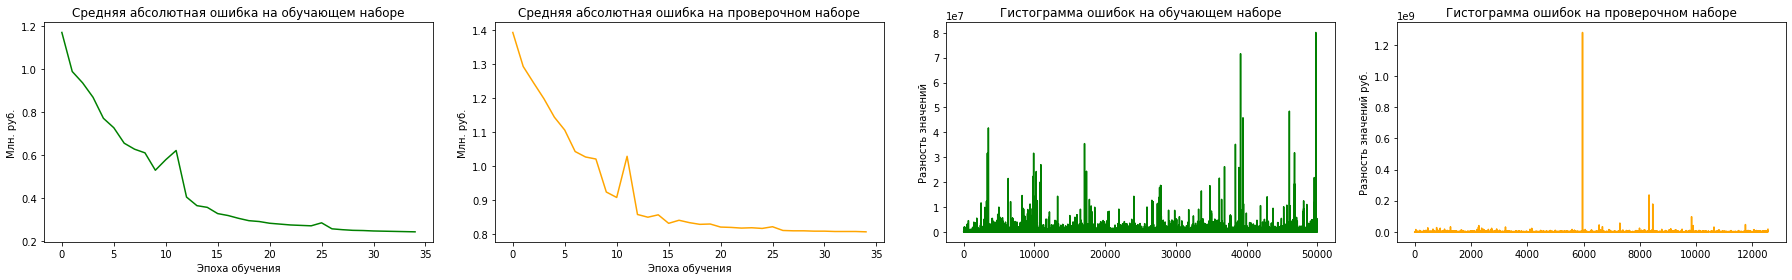


Эпоха 17 модуль ошибки 0.807

Эпоха: 18 / 6  |  MAE на тестовой выборке: 0.807  |  MAE на обучающей выборке: 0.242
Среднее отклонение на тестовой выборке: 102068.57 руб.  |  Среднее отклонение на обучающей выборке: 1612.47 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 5 мин. 48 сек.
Время до конца обучения: -1 мин. -57 сек.


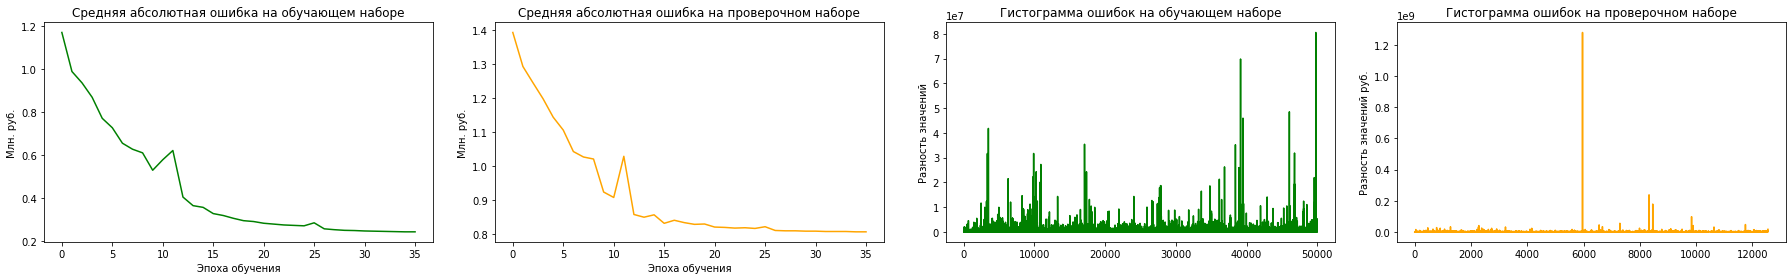


Эпоха 18 модуль ошибки 0.807

Эпоха: 19 / 6  |  MAE на тестовой выборке: 0.807  |  MAE на обучающей выборке: 0.241
Среднее отклонение на тестовой выборке: 102012.97 руб.  |  Среднее отклонение на обучающей выборке: 1593.49 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 5 мин. 58 сек.
Время до конца обучения: -2 мин. -4 сек.


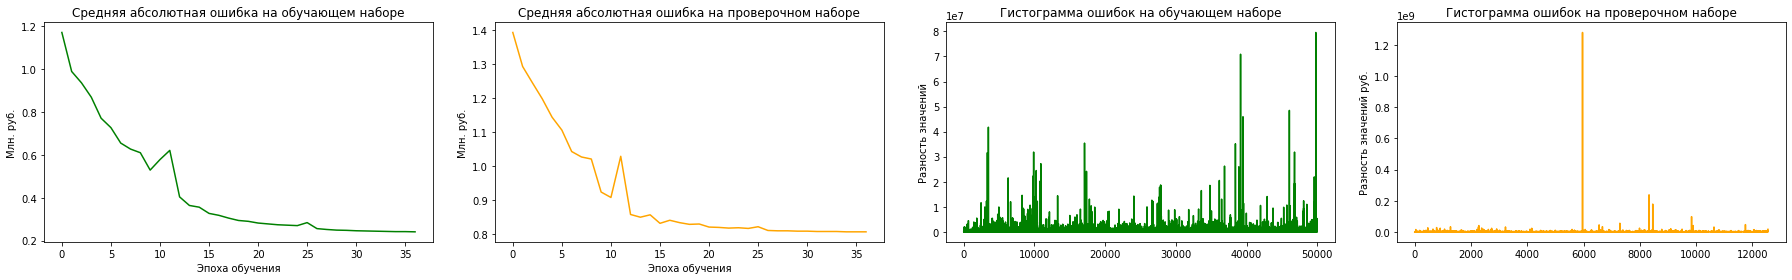


Эпоха 12 модуль ошибки 0.806

Эпоха: 13 / 6  |  MAE на тестовой выборке: 0.806  |  MAE на обучающей выборке: 0.241
Среднее отклонение на тестовой выборке: 101728.6 руб.  |  Среднее отклонение на обучающей выборке: 1543.35 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 6 мин. 8 сек.
Время до конца обучения: -1 мин. -8 сек.


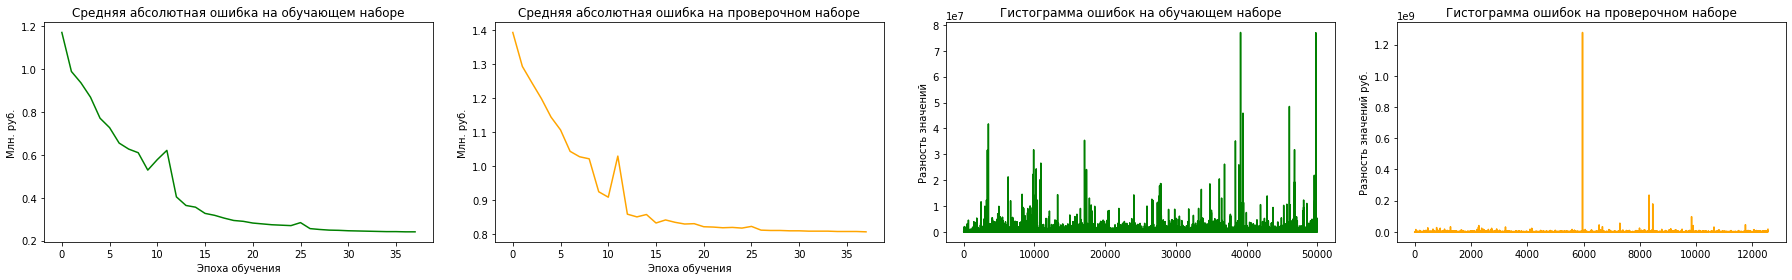


Эпоха 13 модуль ошибки 0.807

Эпоха: 14 / 6  |  MAE на тестовой выборке: 0.807  |  MAE на обучающей выборке: 0.24
Среднее отклонение на тестовой выборке: 102136.7 руб.  |  Среднее отклонение на обучающей выборке: 1598.32 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 6 мин. 17 сек.
Время до конца обучения: -1 мин. -16 сек.


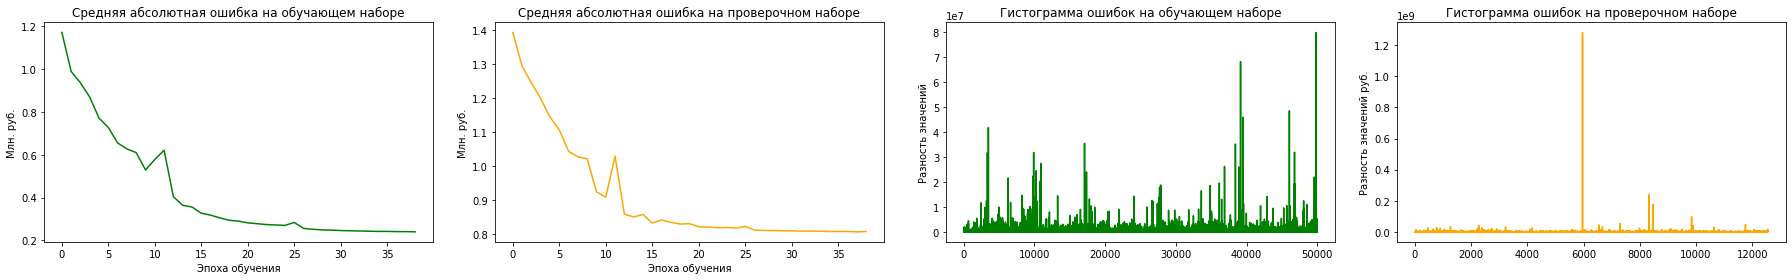


Эпоха 14 модуль ошибки 0.807

Эпоха: 15 / 6  |  MAE на тестовой выборке: 0.807  |  MAE на обучающей выборке: 0.24
Среднее отклонение на тестовой выборке: 102358.89 руб.  |  Среднее отклонение на обучающей выборке: 1611.64 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 6 мин. 27 сек.
Время до конца обучения: -1 мин. -27 сек.


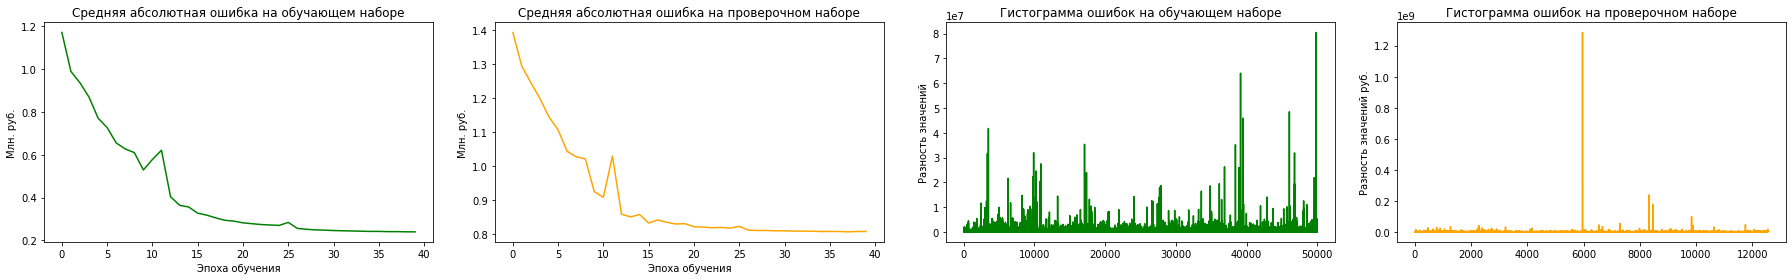


Эпоха 15 модуль ошибки 0.806

Эпоха: 16 / 6  |  MAE на тестовой выборке: 0.806  |  MAE на обучающей выборке: 0.239
Среднее отклонение на тестовой выборке: 102056.79 руб.  |  Среднее отклонение на обучающей выборке: 1555.95 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 6 мин. 37 сек.
Время до конца обучения: -1 мин. -36 сек.


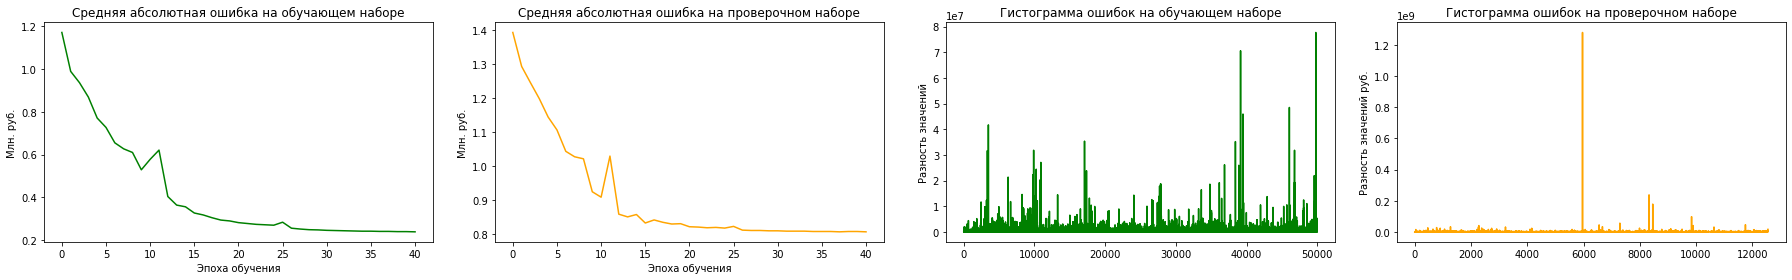


Эпоха 16 модуль ошибки 0.806

Эпоха: 17 / 6  |  MAE на тестовой выборке: 0.806  |  MAE на обучающей выборке: 0.239
Среднее отклонение на тестовой выборке: 101918.73 руб.  |  Среднее отклонение на обучающей выборке: 1532.46 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 6 мин. 46 сек.
Время до конца обучения: -1 мин. -46 сек.


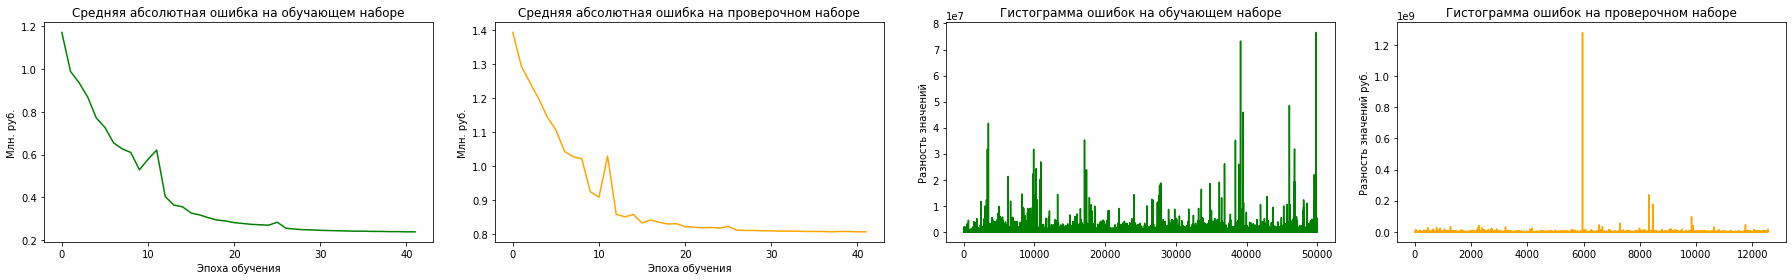


Эпоха 17 модуль ошибки 0.806

Эпоха: 18 / 6  |  MAE на тестовой выборке: 0.806  |  MAE на обучающей выборке: 0.238
Среднее отклонение на тестовой выборке: 102115.55 руб.  |  Среднее отклонение на обучающей выборке: 1547.11 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 6 мин. 56 сек.
Время до конца обучения: -1 мин. -55 сек.


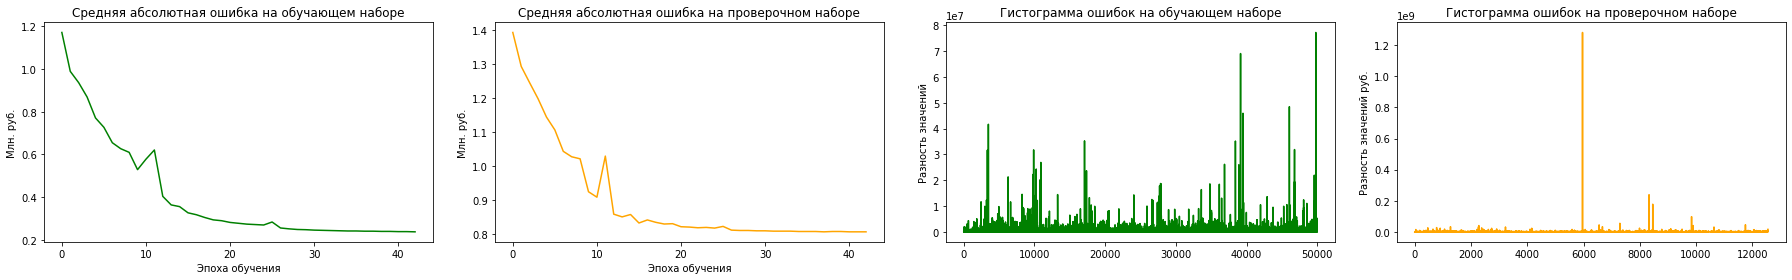


Эпоха 18 модуль ошибки 0.806

Эпоха: 19 / 6  |  MAE на тестовой выборке: 0.806  |  MAE на обучающей выборке: 0.239
Среднее отклонение на тестовой выборке: 101731.99 руб.  |  Среднее отклонение на обучающей выборке: 1547.38 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 7 мин. 5 сек.
Время до конца обучения: -2 мин. -4 сек.


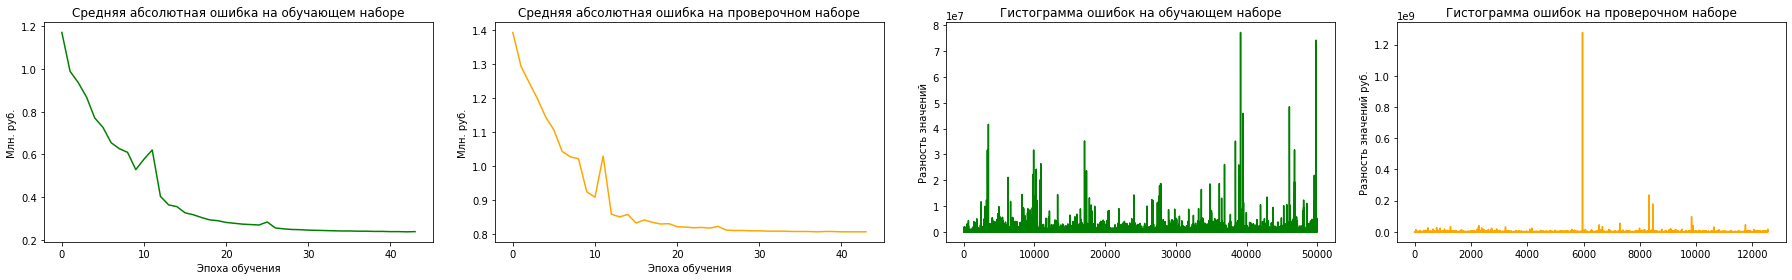


Эпоха 19 модуль ошибки 0.806

Эпоха: 20 / 6  |  MAE на тестовой выборке: 0.806  |  MAE на обучающей выборке: 0.238
Среднее отклонение на тестовой выборке: 101858.32 руб.  |  Среднее отклонение на обучающей выборке: 1494.8 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 7 мин. 15 сек.
Время до конца обучения: -2 мин. -17 сек.


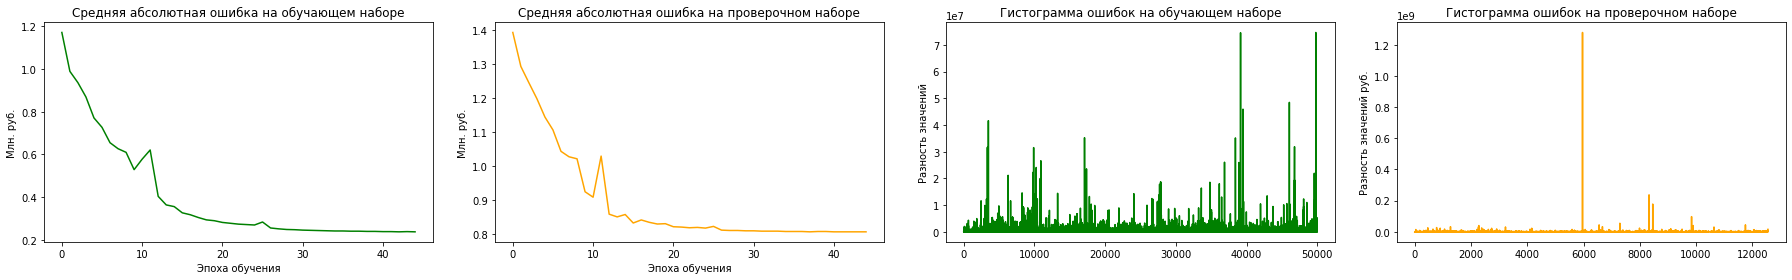


Эпоха 20 модуль ошибки 0.806

Эпоха: 21 / 6  |  MAE на тестовой выборке: 0.806  |  MAE на обучающей выборке: 0.237
Среднее отклонение на тестовой выборке: 101680.4 руб.  |  Среднее отклонение на обучающей выборке: 1569.31 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 7 мин. 25 сек.
Время до конца обучения: -2 мин. -24 сек.


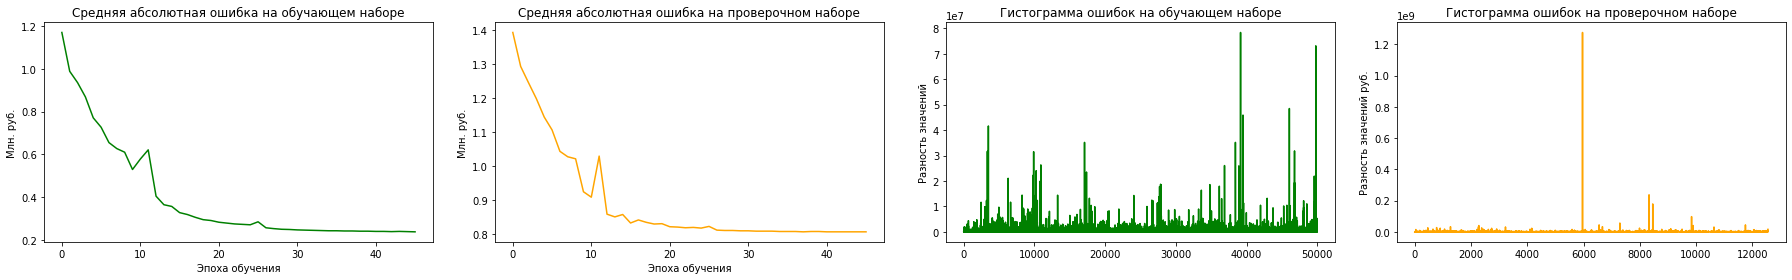


Эпоха 21 модуль ошибки 0.805

Эпоха: 22 / 6  |  MAE на тестовой выборке: 0.805  |  MAE на обучающей выборке: 0.237
Среднее отклонение на тестовой выборке: 101398.79 руб.  |  Среднее отклонение на обучающей выборке: 1691.07 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 7 мин. 34 сек.
Время до конца обучения: -2 мин. -33 сек.


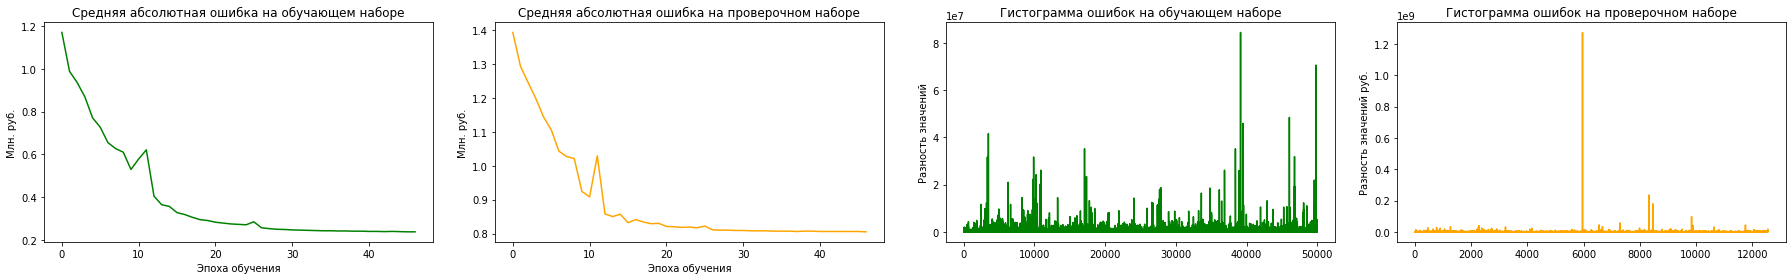


Эпоха 22 модуль ошибки 0.805

Эпоха: 23 / 6  |  MAE на тестовой выборке: 0.805  |  MAE на обучающей выборке: 0.237
Среднее отклонение на тестовой выборке: 101555.06 руб.  |  Среднее отклонение на обучающей выборке: 1629.01 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 7 мин. 44 сек.
Время до конца обучения: -2 мин. -41 сек.


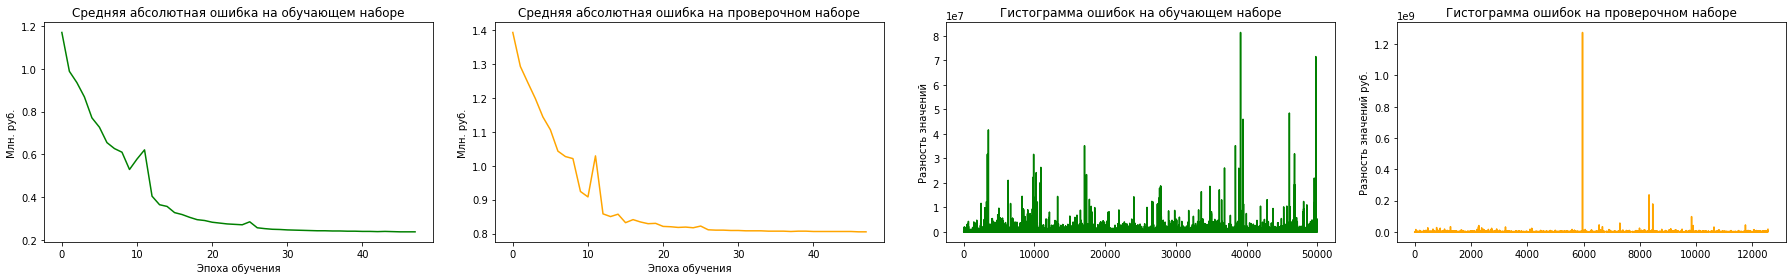


Эпоха 23 модуль ошибки 0.805

Эпоха: 24 / 6  |  MAE на тестовой выборке: 0.805  |  MAE на обучающей выборке: 0.236
Среднее отклонение на тестовой выборке: 101379.68 руб.  |  Среднее отклонение на обучающей выборке: 1692.91 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 7 мин. 54 сек.
Время до конца обучения: -2 мин. -52 сек.


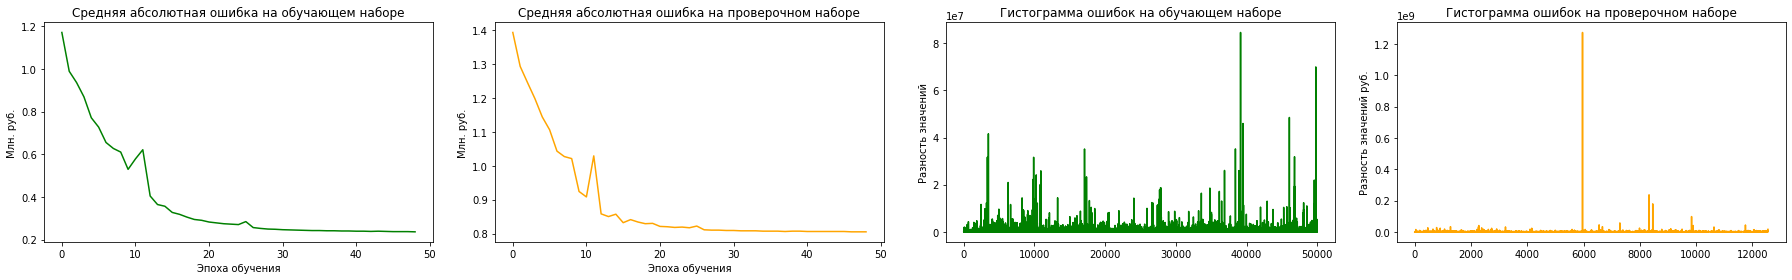


Эпоха 24 модуль ошибки 0.804

Эпоха: 25 / 6  |  MAE на тестовой выборке: 0.804  |  MAE на обучающей выборке: 0.236
Среднее отклонение на тестовой выборке: 101152.56 руб.  |  Среднее отклонение на обучающей выборке: 1797.04 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 8 мин. 3 сек.
Время до конца обучения: -3 мин. 0 сек.


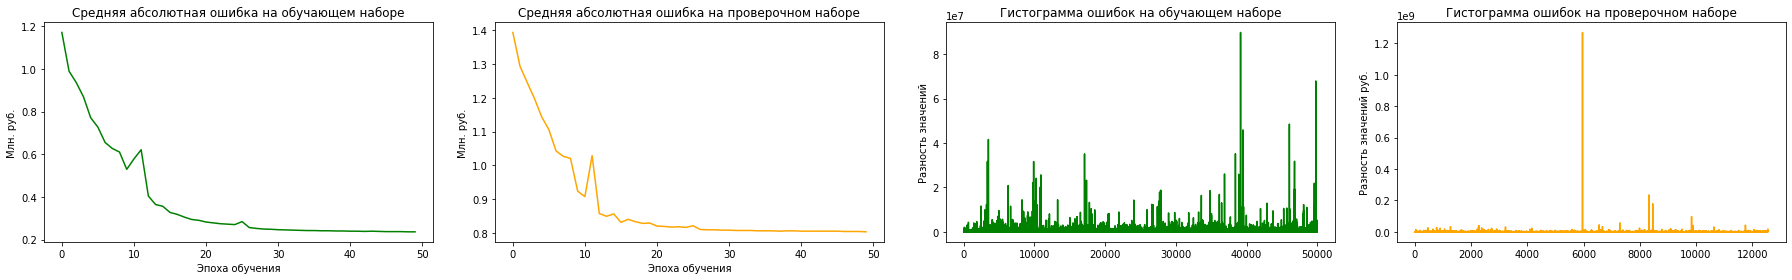


Эпоха 25 модуль ошибки 0.805

Эпоха: 26 / 6  |  MAE на тестовой выборке: 0.805  |  MAE на обучающей выборке: 0.236
Среднее отклонение на тестовой выборке: 101518.21 руб.  |  Среднее отклонение на обучающей выборке: 1640.26 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 8 мин. 13 сек.
Время до конца обучения: -3 мин. -10 сек.


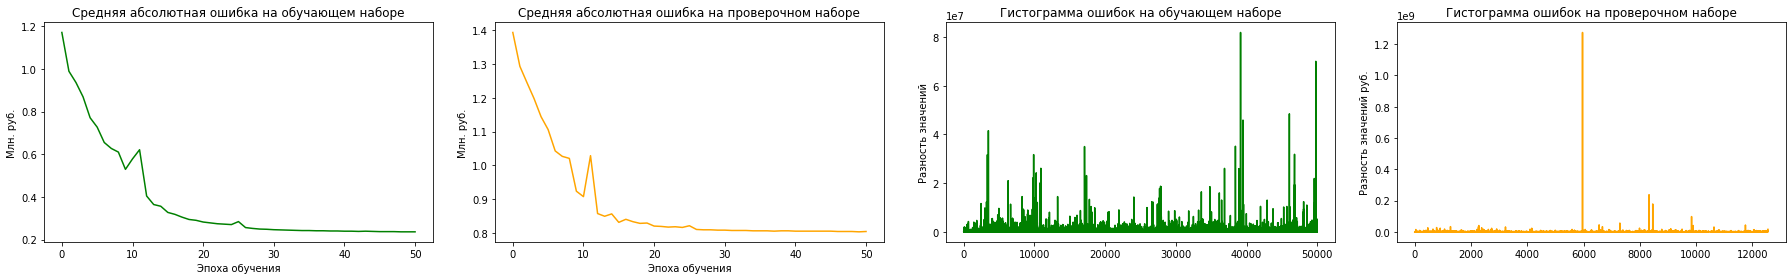


Эпоха 26 модуль ошибки 0.804

Эпоха: 27 / 6  |  MAE на тестовой выборке: 0.804  |  MAE на обучающей выборке: 0.236
Среднее отклонение на тестовой выборке: 101150.3 руб.  |  Среднее отклонение на обучающей выборке: 1799.9 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 8 мин. 22 сек.
Время до конца обучения: -3 мин. -19 сек.


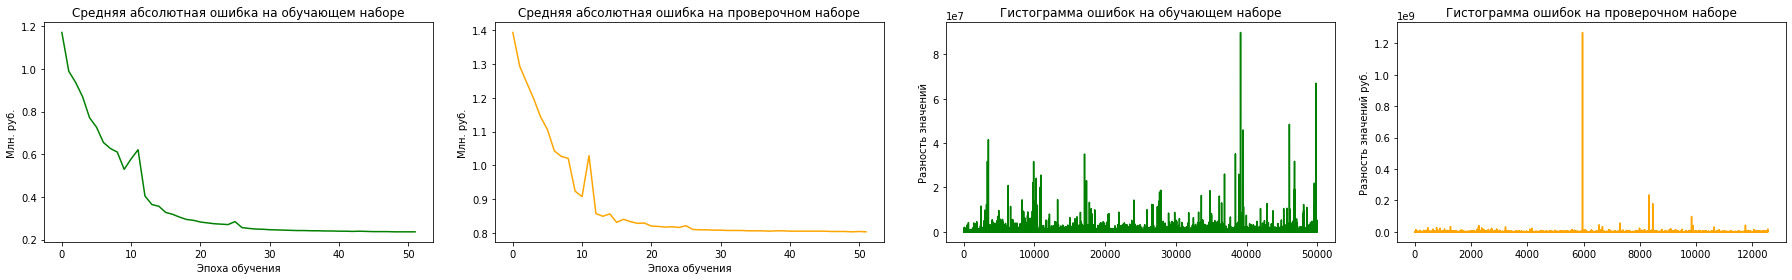


Эпоха 27 модуль ошибки 0.805

Эпоха: 28 / 6  |  MAE на тестовой выборке: 0.805  |  MAE на обучающей выборке: 0.236
Среднее отклонение на тестовой выборке: 101299.89 руб.  |  Среднее отклонение на обучающей выборке: 1739.95 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 8 мин. 32 сек.
Время до конца обучения: -3 мин. -29 сек.


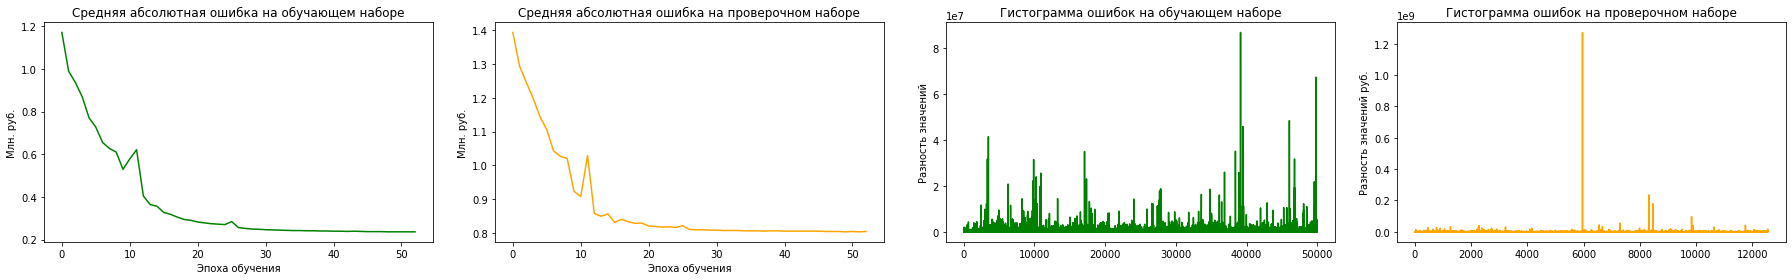


Эпоха 28 модуль ошибки 0.804

Эпоха: 29 / 6  |  MAE на тестовой выборке: 0.804  |  MAE на обучающей выборке: 0.235
Среднее отклонение на тестовой выборке: 101107.93 руб.  |  Среднее отклонение на обучающей выборке: 1819.53 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 8 мин. 41 сек.
Время до конца обучения: -3 мин. -45 сек.


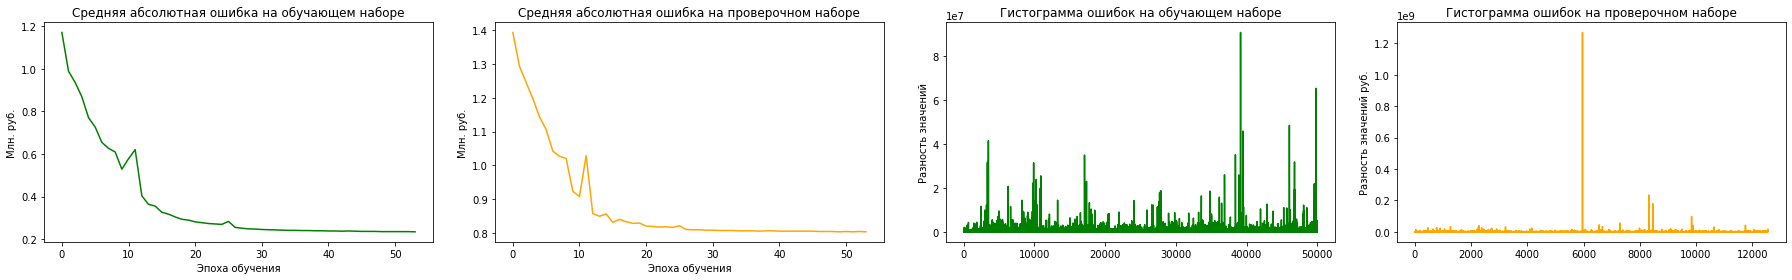


Эпоха 29 модуль ошибки 0.804

Эпоха: 30 / 6  |  MAE на тестовой выборке: 0.804  |  MAE на обучающей выборке: 0.234
Среднее отклонение на тестовой выборке: 101127.33 руб.  |  Среднее отклонение на обучающей выборке: 1812.34 руб.
Время обучения на эпохе: 9 сек.
Общее время обучения: 8 мин. 51 сек.
Время до конца обучения: -3 мин. -48 сек.


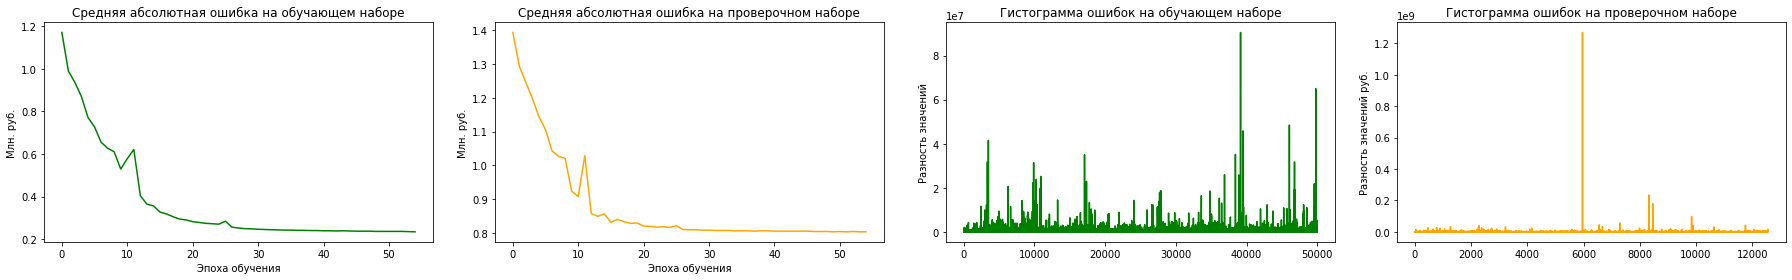

In [ ]:
# Простая Dense cеть
mae_test=[]
mae_train=[]
filename = ""

all_time = 0
epoch_spend_time = 0

epochs = 30
learning_rate = 0.001
start_time = last_check_time = time.time()

pltMae = LambdaCallback(on_epoch_end=on_epoch_end_for_moscow_data)

input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation='relu')(input1)
x2 = Dense(250, activation= 'relu')(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation= 'relu')(x)
x = Dense(1, activation= 'linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=learning_rate), loss='mae')
model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=epochs, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'acc', 'val_loss', 'val_mae', 'val_acc'])
